In [1]:
import pandas as pd
import numpy as np
import bambi as bmb
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from matplotlib import transforms
from itertools import product
import pyfixest as pf
import statsmodels.formula.api as smf
from patsy import dmatrices, dmatrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

np.random.seed(100)


::: {.callout-note}
## Summary 
__WORK IN PROGRESS__

_Inference, causal and otherwise, is biased in the presence of implicit group level confounds. Regression modelling can account for these risks but we have to appropriately condition our inference steps on the __right__ group level effects. It is not always obvious how to incorporate these factors in our modelling. Fixed Effects and (Hierarchical) Random Effects are variously use to to express variation in the outcome due to group level effects. Question of correct functional form become more complicated again when we have to account for variation across multiple groups interactions. We explore these questions in assessing class/school/pupil dynamics before applying these considerations to causal inference more directly. _

_Two Way Fixed Effects (TWFE) regression models are often used in Differences-in-Differences causal inference designs to estimate treatment effects while accounting for variation due to group effects in two dimensions. We will explore the relationship between TWFE and Mundlak like regressions in DiD and Event Study designs, showing how sound inferential strategies rely on saturated models with richly parameterised specifications. In particular we'll see how TWFE breaks down in cases of staggered treatment regimes, and how to fix it._
:::

# Architectures and Free Parameters

> “There are no rules of architecture for a castle in the clouds.” - G.K. Chesterton

It's an ongoing struggle to discern the shape of the tracks on which you travel and the off-ramps available. Hurtling into the future, you pivot at junctions, hoping for the best. You may imagine your next choice will be the one where everything falls into place! All the plans are arrayed, details pinned down - but the final outcomes are confounded by a plethora of interaction effects and that understanding only arrives incrementally. You may seek to learn from the past with a cursory review of history, but the details matters because they structure the implied future choices. It is the structural details of hierarchies and interactions that determine the path of the tracks, and the architecture the holds up your future. Freedom is not whimsy or wanton action. Choice is free when taken within the confines of tolerable bounds. 

In statistical modelling we seek to discover what is plausibly realised within such bounds. We learn from the past to discern the shape of the processes which determine the future. Different models yield different insights into those structures which govern our trajectories. Which parameters are "free", and which are decisively characterised? Which realities are contestable and which non-negotiable? In this post we will dive into the way in which different inferential methodologies yield different insights into how group-level confounding constrains the realisations of our parameter space and shapes the architecture of causal inference.

Difference in Differences estimation is core a topic in contemporary social science and causal inference. It is a compelling methodology for licensing inferential statements, but it is not a panacea. The method makes substantive assumptions about the treatment regime and the trends in the process before the treatment is introduced, but it also requires that the data is rich enough to mandate the intended interpretation of a heavily parameterised estimation model. The two-way fixed effects models attempt to tightly estimate the treatment effect by controlling for all sources of variation in our treatment due to group level factors in the DiD designs. These controls isolate the variation due to actual treatment by pinning down the effects of interactions between treatment-units and time.  We will see how these models and their intended interpretation come apart quickly in the face of staggered treatment roll-outs. We will also show how to fix these issues. 

## Estimation and Group Effects

First consider an estimation example due to Richard McElreath's [lecture series](https://www.youtube.com/playlist?list=PLDcUM9US4XdPz-KxHM4XHt7uUVGWWVSus) where we examine the various parameter recovery options available in the case of group level confounding. Define a data generating process determined by group level effects:


In [2]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

N_groups = 30
N_id = 3000
a0 = -2
bXY = 1
bZY = -0.5
g = np.random.choice(range(N_groups), size=N_id, replace=True)
Ug = np.random.normal(1.5, size=N_groups)

X = np.random.normal(Ug[g], size=N_id)
Z = np.random.normal(size=N_groups)

s = a0 + bXY*X + Ug[g] + bZY*Z[g]
p = inv_logit(s)
Y = np.random.binomial(n=1, p=p)


sim_df = pd.DataFrame({'Y': Y, 'p': p, 's': s, 'g': g, 'X': X, 'Z': Z[g]})
sim_df

Y         p         s   g         X         Z
0     1  0.943243  2.810542   8  1.384072 -1.818302
1     0  0.593872  0.379996  24  1.047128 -0.242817
2     1  0.874945  1.945406   3  2.340418 -0.650122
3     0  0.317089 -0.767181   7  0.550504  0.795680
4     1  0.699030  0.842684  23  1.183011 -0.111692
...  ..       ...       ...  ..       ...       ...
2995  1  0.996046  5.529008   8  4.102537 -1.818302
2996  0  0.339112 -0.667253   3 -0.272241 -0.650122
2997  1  0.662931  0.676383  22  2.395946  0.817874
2998  1  0.846683  1.708821  15  1.568391  1.026179
2999  1  0.995504  5.399987   8  3.973517 -1.818302

[3000 rows x 6 columns]

This is a bernoulli outcome with group level confounds. If we model this relationship the confounding effects will bias naive parameter estimates on the covariates $X$, $Z$. Seeing different results as we explore different ways of parameterising the relationships.

::: {.callout-warning title="Terminology Warning"}
There is a huge degree of confusion over the meaing of the terms "Fixed Effects" and "Random Effects". Within this blog post we will mean the population level parameters. 
 $$\beta X$$ 
 
for an individual variable $X$ when we refer to __fixed effects__. Corresspondingly we will refer to group-level parameters $\beta_{g}$

 $$\Big(\underbrace{\beta}_{pop} + \underbrace{\beta_{g}}_{group}\Big)X$$
 

which are incorporated into our model equation modifying population level parameters as __random effects.__ We will generally use Wilkison notation to specify these choices where random effects for modifying a population are denoted with a conditional bar over the variable `( X | group)` and fixed effects are specified by just including the variable in the equation i.e. `y ~ X + (Z | group)` where X has a fixed effect parameterisation and Z a random effects parameterisation. We can also create indicator variables for group membership using this syntax with `y ~ C(group) + X + Z` where under the hood we pivot the group category into a zero-one variables indicating group membership. This parameterisation means each indicator variable (one for each level of the grouping variable) will receive a fixed effects population parameter.   
:::

### Naive Model

The formula syntax for `Bambi` also enables us to specify generalised linear models with bernoulli outcomes. 


In [3]:
#| output: false
#| 
naive_model = bmb.Model(f"Y['>.5'] ~ X + Z ", sim_df, 
family="bernoulli")
naive_idata = naive_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:02.264692


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:01.854901


Transforming variables...


Transformation time = 0:00:00.053806


Computing Log Likelihood...


Log Likelihood time = 0:00:00.308490


In [4]:
az.summary(naive_idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.994  0.079  -1.143   -0.847      0.001    0.001    4820.0   
X          1.311  0.052   1.209    1.407      0.001    0.001    3130.0   
Z         -0.615  0.049  -0.707   -0.525      0.001    0.001    3042.0   

           ess_tail  r_hat  
Intercept    3314.0    1.0  
X            2676.0    1.0  
Z            2986.0    1.0

Here we see that all three parameter estimates are biased away from their true values. Let's try a simple fixed effects approach that adds indicator variables for all but one of the group levels.  

### Fixed Effects Model

The additional syntax for creating the group level indicator variables is specified here. 


In [5]:
#| output: false
#| 
fixed_effects_model = bmb.Model(f"Y['>.5'] ~ C(g) + X + Z", sim_df, 
family="bernoulli")
fixed_effects_idata = fixed_effects_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:00.516861


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:29.000452


Transforming variables...


Transformation time = 0:00:00.066136


Computing Log Likelihood...


Log Likelihood time = 0:00:00.542236


In [6]:
az.summary(fixed_effects_idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.214  1.474  -2.871    2.515      0.077    0.055     364.0   
X          0.977  0.059   0.869    1.087      0.001    0.001    2875.0   
Z         -0.177  1.364  -2.656    2.358      0.070    0.050     378.0   

           ess_tail  r_hat  
Intercept     463.0   1.01  
X            2710.0   1.00  
Z             510.0   1.01

Now we see that the coefficient on the $X$ variable seem correct, but the coefficient on $Z$ is wildly wrong. Indeed the uncertainty interval on the $Z$ coefficient is huge. The fixed effect model was unable to learn anything about the correct parameter. Whereas the naive model seems to learn the correct $Z$ parameter but over estimates the $X$ coefficient. These are the kinds of trade-offs we need to be wary of as we account for the complexities of extensive group interactions in our model's functional form. 


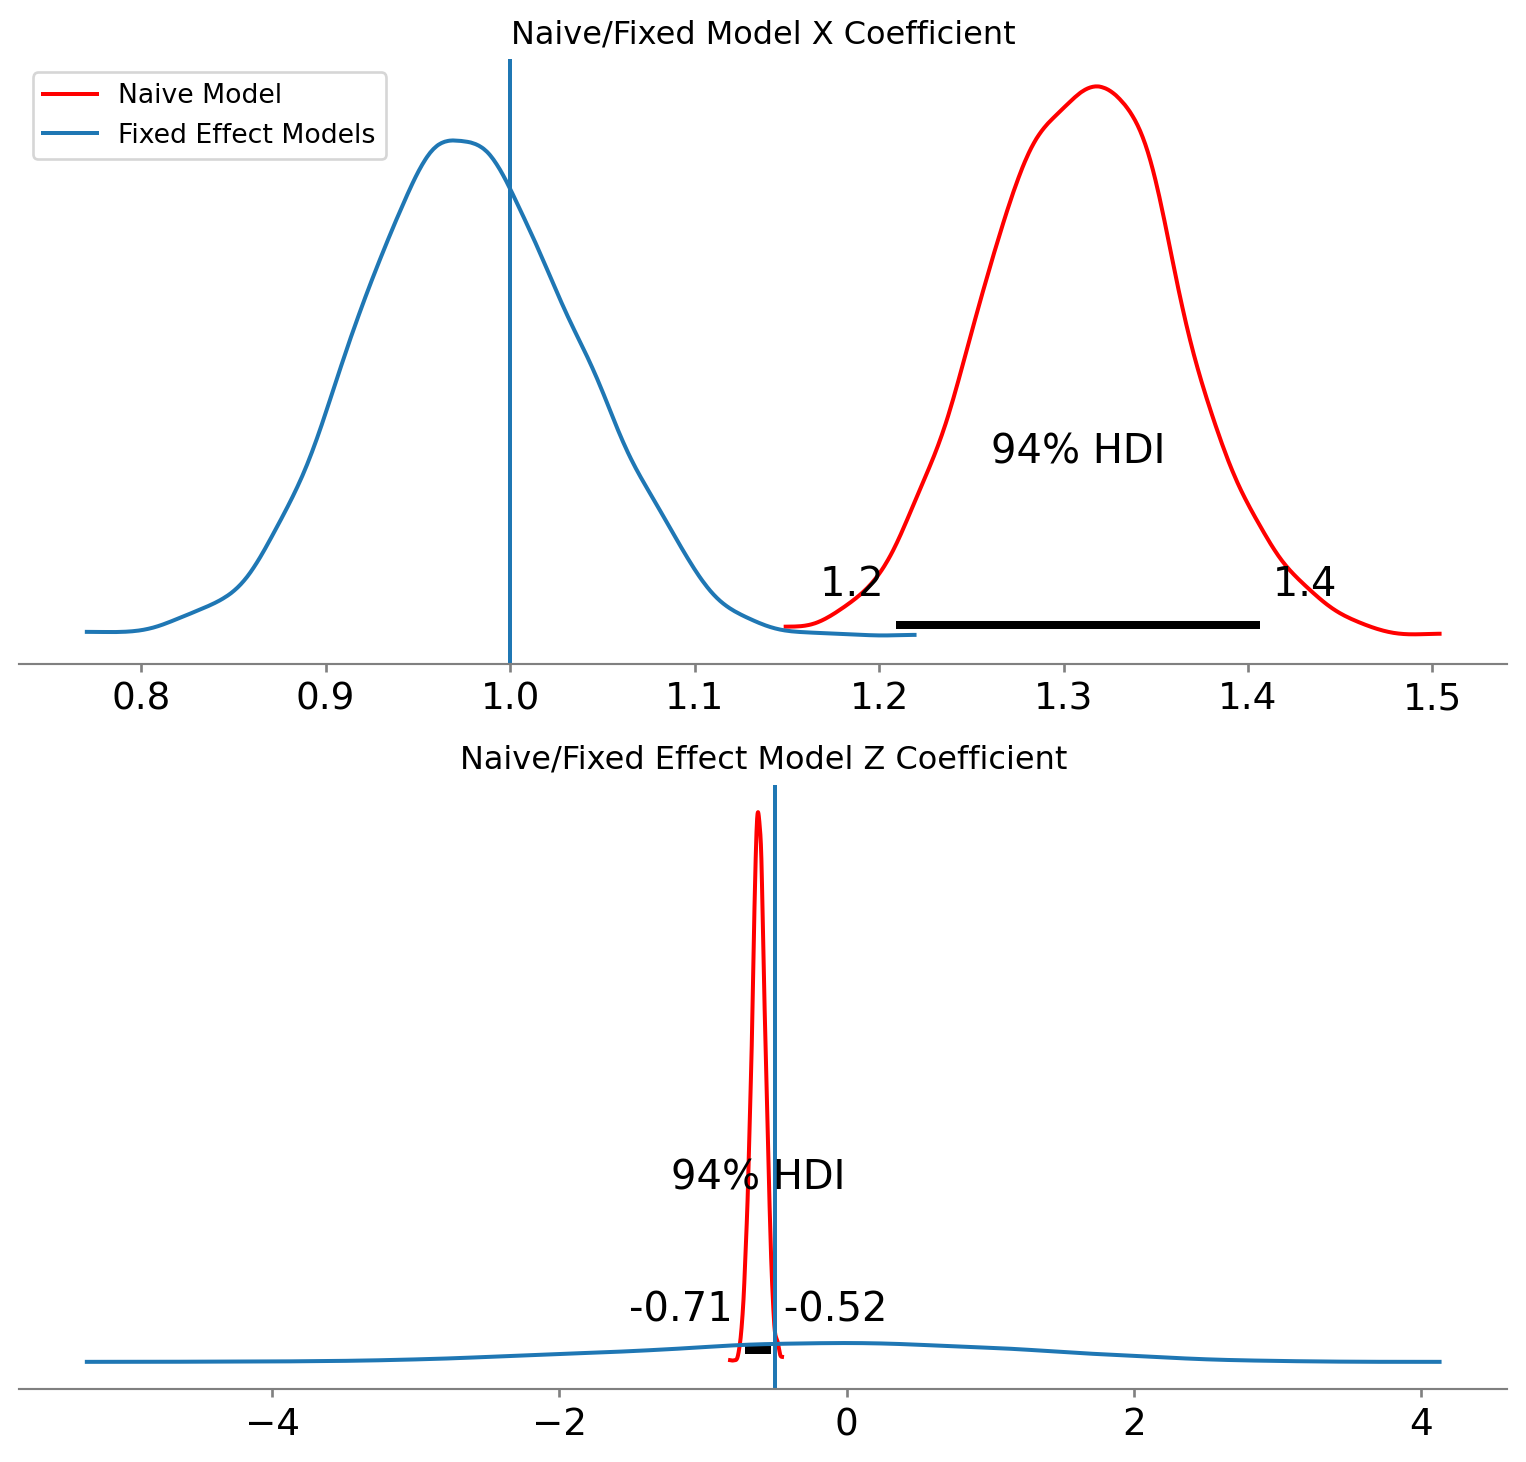

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(10, 9))
axs = axs.flatten()

az.plot_posterior(naive_idata, var_names=['X'], ax=axs[0], 
point_estimate=None, color='red', label='Naive Model')
axs[0].axvline(1)

az.plot_posterior(fixed_effects_idata , var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', label='Fixed Effect Models')
axs[0].set_title("Naive/Fixed Model X Coefficient")

az.plot_posterior(naive_idata, var_names=['Z'], ax=axs[1], point_estimate=None,  color='red', ref_val_color='black')


az.plot_posterior(fixed_effects_idata , var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide')

axs[1].set_title("Naive/Fixed Effect Model Z Coefficient")
axs[1].axvline(-0.5);


We now want to try another approach to handle to the group confounding that involves a hierarchical approach to add group level effects to the intercept term. 

### Multilevel Model

The syntax for the random effects model is similar. 


In [8]:
#| output: false

multilevel_model = bmb.Model(f"Y['>.5'] ~ (1 | g) + X + Z", sim_df, 
family="bernoulli")
multilevel_model_idata = multilevel_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:00.791255


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.236693


Transforming variables...


Transformation time = 0:00:00.079595


Computing Log Likelihood...


Log Likelihood time = 0:00:00.482519


This method posits a view that there is a shared underlying process generating each instance of group-behaviour i.e. the reliased values of the outcome within each group. We replace the indivdual fixed effects indicator columns with additional parameters modifying the intercept.


In [9]:
az.summary(multilevel_model_idata, var_names=['X', 'Z', 'Intercept'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
X          1.025  0.059   0.916    1.138      0.001    0.001    4119.0   
Z         -0.596  0.170  -0.915   -0.264      0.006    0.004     778.0   
Intercept -0.556  0.199  -0.960   -0.205      0.007    0.005     729.0   

           ess_tail  r_hat  
X            2845.0   1.00  
Z            1341.0   1.01  
Intercept    1324.0   1.00

Next we'll apply the Mundlak device method which adds the group mean back to each observation as a covariate. 

### Mundlak Model

For this technique we supply group aggregate mean values as additional columns. This somewhat absolves of the requirement to include an extra multiplicity of parameters. It's more akin to feature creation than model specification, but it serves the same purpose - it accounts for group level variation and provides a mechanism for the model to learn the appropriate weights to accord each group in the final calculation. 


In [10]:
#| output: false

sim_df['group_mean'] = sim_df.groupby('g')['X'].transform(np.mean)

sim_df['group_mean_Z'] = sim_df.groupby('g')['Z'].transform(np.mean)

mundlak_model = bmb.Model(f"Y['>.5'] ~ (1 | g) + X + Z + group_mean", sim_df, 
family="bernoulli")
mundlak_idata = mundlak_model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Modeling the probability that Y==1


Compiling...


Compilation time = 0:00:00.644147


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:06.419629


Transforming variables...


Transformation time = 0:00:00.058977


Computing Log Likelihood...


Log Likelihood time = 0:00:00.485189


In [11]:
az.summary(mundlak_idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -1.910  0.136  -2.150   -1.639      0.002    0.002    3647.0   
X          0.951  0.059   0.839    1.058      0.001    0.001    4887.0   
Z         -0.444  0.063  -0.565   -0.325      0.001    0.001    3113.0   

           ess_tail  r_hat  
Intercept    3032.0    1.0  
X            2899.0    1.0  
Z            2480.0    1.0

We can now plot all the parameter recovery models together and we'll see that there are some trade-offs between the fixed effects and random effects varieties of the modelling. 

### Plotting the Comparisons


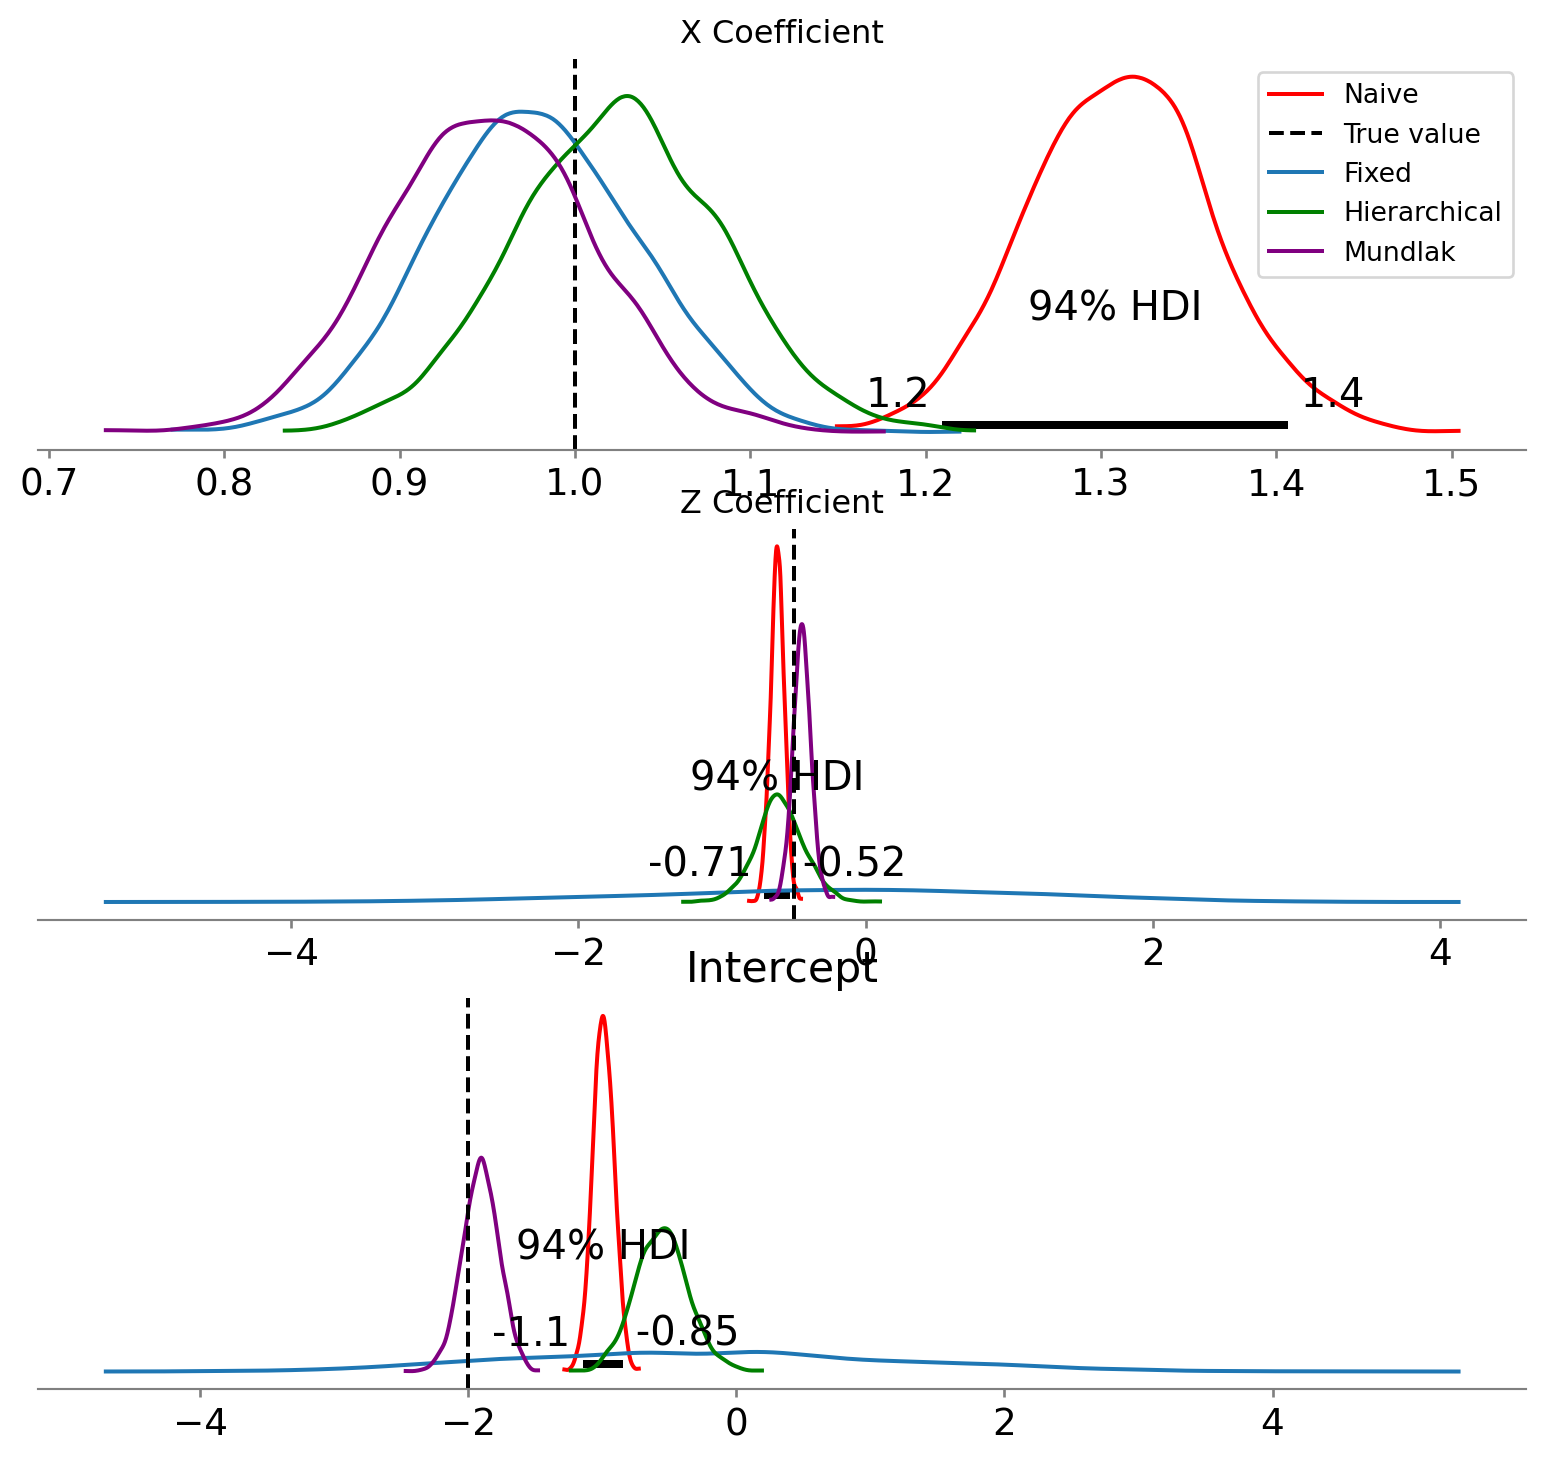

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(10, 9))
axs = axs.flatten()

az.plot_posterior(naive_idata, var_names=['X'], ax=axs[0], 
point_estimate=None, color='red', label='Naive')
axs[0].axvline(1, color='k', linestyle='--', label='True value')

az.plot_posterior(fixed_effects_idata , var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', label='Fixed')

az.plot_posterior(multilevel_model_idata, var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', color='green', label='Hierarchical')

az.plot_posterior(mundlak_idata, var_names=['X'], ax=axs[0], point_estimate=None, hdi_prob='hide', color='purple', label='Mundlak')


axs[0].set_title("X Coefficient")

az.plot_posterior(naive_idata, var_names=['Z'], ax=axs[1], point_estimate=None,  color='red', ref_val_color='black')


az.plot_posterior(fixed_effects_idata , var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide')

az.plot_posterior(multilevel_model_idata, var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide', color='green')

az.plot_posterior(mundlak_idata, var_names=['Z'], ax=axs[1], point_estimate=None, hdi_prob='hide', color='purple')

axs[1].set_title("Z Coefficient")
axs[1].axvline(-0.5, color='k', linestyle='--');

az.plot_posterior(naive_idata, var_names=['Intercept'], ax=axs[2], point_estimate=None,  color='red', ref_val_color='black')


az.plot_posterior(fixed_effects_idata , var_names=['Intercept'], ax=axs[2], point_estimate=None, hdi_prob='hide')

az.plot_posterior(multilevel_model_idata, var_names=['Intercept'], ax=axs[2], point_estimate=None, hdi_prob='hide', color='green')

az.plot_posterior(mundlak_idata, var_names=['Intercept'], ax=axs[2], point_estimate=None, hdi_prob='hide', color='purple')

axs[2].axvline(-2, color='k', linestyle='--');

Importantly, the fixed effects model is focused on recovering the treatment effect on the $X$ covariate somewhat at the expense of accuracy on the other systematic components of the model. However, this focus renders the model less predictively accurate. Compare the models on the cross-validation score and we see how the hierarchical mundlak model is to be preferred.


In [13]:
compare_df = az.compare({'naive': naive_idata, 'fixed': fixed_effects_idata, 'hierarchical': multilevel_model_idata, 
'mundlak': mundlak_idata})
compare_df

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank     elpd_loo      p_loo  elpd_diff        weight  \
mundlak          0 -1209.470500  12.237091   0.000000  9.419597e-01   
hierarchical     1 -1218.905252  28.042243   9.434751  1.996911e-16   
fixed            2 -1221.240374  33.572279  11.769874  3.024154e-02   
naive            3 -1295.475023   2.959038  86.004523  2.779872e-02   

                     se        dse  warning scale  
mundlak       30.216814   0.000000    False   log  
hierarchical  30.410032   4.489627    False   log  
fixed         31.737689   5.234804     True   log  
naive         29.529151  13.007440    False   log

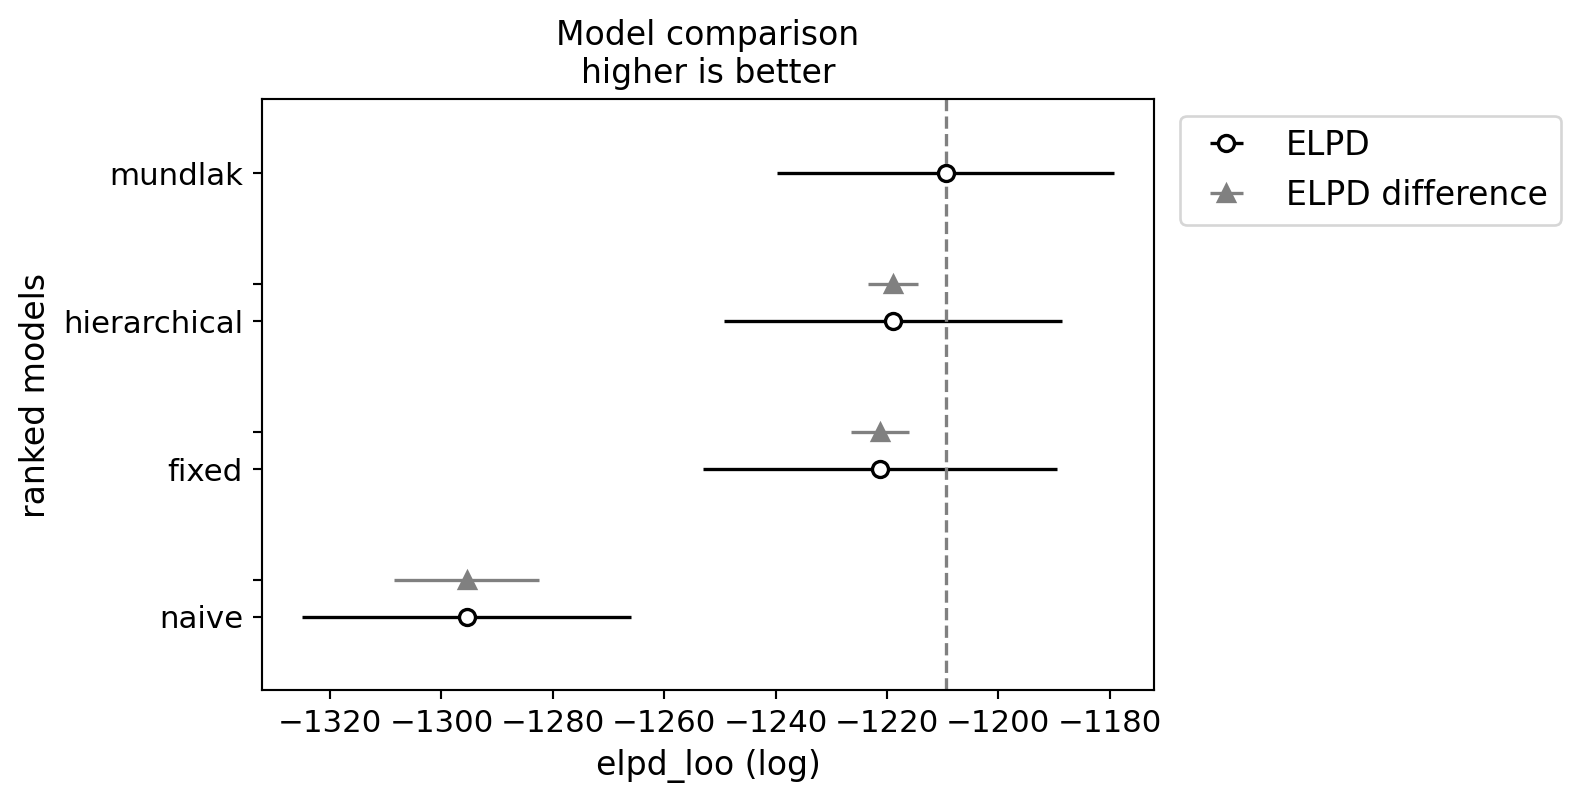

In [14]:
az.plot_compare(compare_df);

### Full Luxury Bayesian Mundlak Machine

As good Bayesians we might be worry about the false precision of adding simple point estimates for the group mean covariates in the Mundlak model. We can remedy this by explicitly incorporating these values as an extra parameter and adding uncertainty to the draws on these parameters.  


In [15]:
#| output: false

id_indx, unique_ids = pd.factorize(sim_df["g"])

coords = {'ids': list(range(N_groups))}
with pm.Model(coords=coords) as model: 

    x_data = pm.Data('X_data', sim_df['X'])
    z_data = pm.Data('Z_data', sim_df['Z'])
    y_data = pm.Data('Y_data', sim_df['Y'])

    alpha0 = pm.Normal('Intercept', 0, 1)
    alpha_j = pm.Normal('alpha_j', 0, 1, dims='ids')
    beta_xy = pm.Normal('X', 0, 1)
    beta_zy = pm.Normal('Z', 0, 1)

    group_means = pm.Normal('group_means', sim_df.groupby('g')['X'].mean().values, .1, dims='ids')

    mu = pm.Deterministic('mu', (alpha0 + alpha_j[id_indx]) + beta_xy*x_data + beta_zy*z_data + group_means[id_indx])
    p = pm.Deterministic("p", pm.math.invlogit(mu))
    # likelihood
    pm.Binomial("y", n=1, p=p, observed=y_data)

    idata = pm.sample(idata_kwargs={"log_likelihood": True})

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [Intercept, alpha_j, X, Z, group_means]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [16]:
az.summary(idata, var_names=['Intercept', 'X', 'Z'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -1.887  0.199  -2.276   -1.526      0.007    0.005     890.0   
X          1.005  0.059   0.895    1.118      0.001    0.001    6163.0   
Z         -0.577  0.172  -0.895   -0.252      0.005    0.004    1076.0   

           ess_tail  r_hat  
Intercept    1234.0    1.0  
X            2644.0    1.0  
Z            1996.0    1.0

This model bakes more uncertainty into the process assuming a kind of measurement-error model which may be more or less apt depending on how much data you've acquired and your view of the underlying process. We'll now examine how these considerations play out when there are multiple group-level influences. 

## Nested Groups and Fixed Effects

We've seen how various attempts to account for the group effects can more or less recover the parameters of a complex data generating process with group confounding. Now we want to look at a case where we can have interacting group effects at multiple levels. 

### Pupils within Class Rooms within Schools

A natural three level group hierarchy occurs in the context of educational organisations and business org-charts. We can use this fact to interrogate briefly how inferential statements about treatment effects vary as a function of what and how we control for group level variation. We draw the following data set from _Linear Mixed Models: A Practical Guide Using Statistical Software_.


In [17]:
df = pd.read_csv('classroom.csv')
df['class_mean'] = df.groupby(['classid'])['mathprep'].transform(np.mean)
df['school_mean'] = df.groupby(['schoolid'])['mathprep'].transform(np.mean)
df.head()

sex  minority  mathkind  mathgain   ses  yearstea  mathknow  housepov  \
0    1         1       448        32  0.46       1.0       NaN     0.082   
1    0         1       460       109 -0.27       1.0       NaN     0.082   
2    1         1       511        56 -0.03       1.0       NaN     0.082   
3    0         1       449        83 -0.38       2.0     -0.11     0.082   
4    0         1       425        53 -0.03       2.0     -0.11     0.082   

   mathprep  classid  schoolid  childid  class_mean  school_mean  
0      2.00      160         1        1        2.00     2.909091  
1      2.00      160         1        2        2.00     2.909091  
2      2.00      160         1        3        2.00     2.909091  
3      3.25      217         1        4        3.25     2.909091  
4      3.25      217         1        5        3.25     2.909091

The data has three distinct levels: (1) the child or pupil and their demographic attributes and outcome variable `mathgain`, (2) the classroom and the teacher level attributes such as their experience `yearstea` and a record of their mathematics courses taken `mathprep`, (3) school and neighbourhood level with features describing poverty measures in the vicinity `housepov`. 

We'll plot the child's outcome `mathgain` against the `mathprep` and distinguish the patterns by school.  


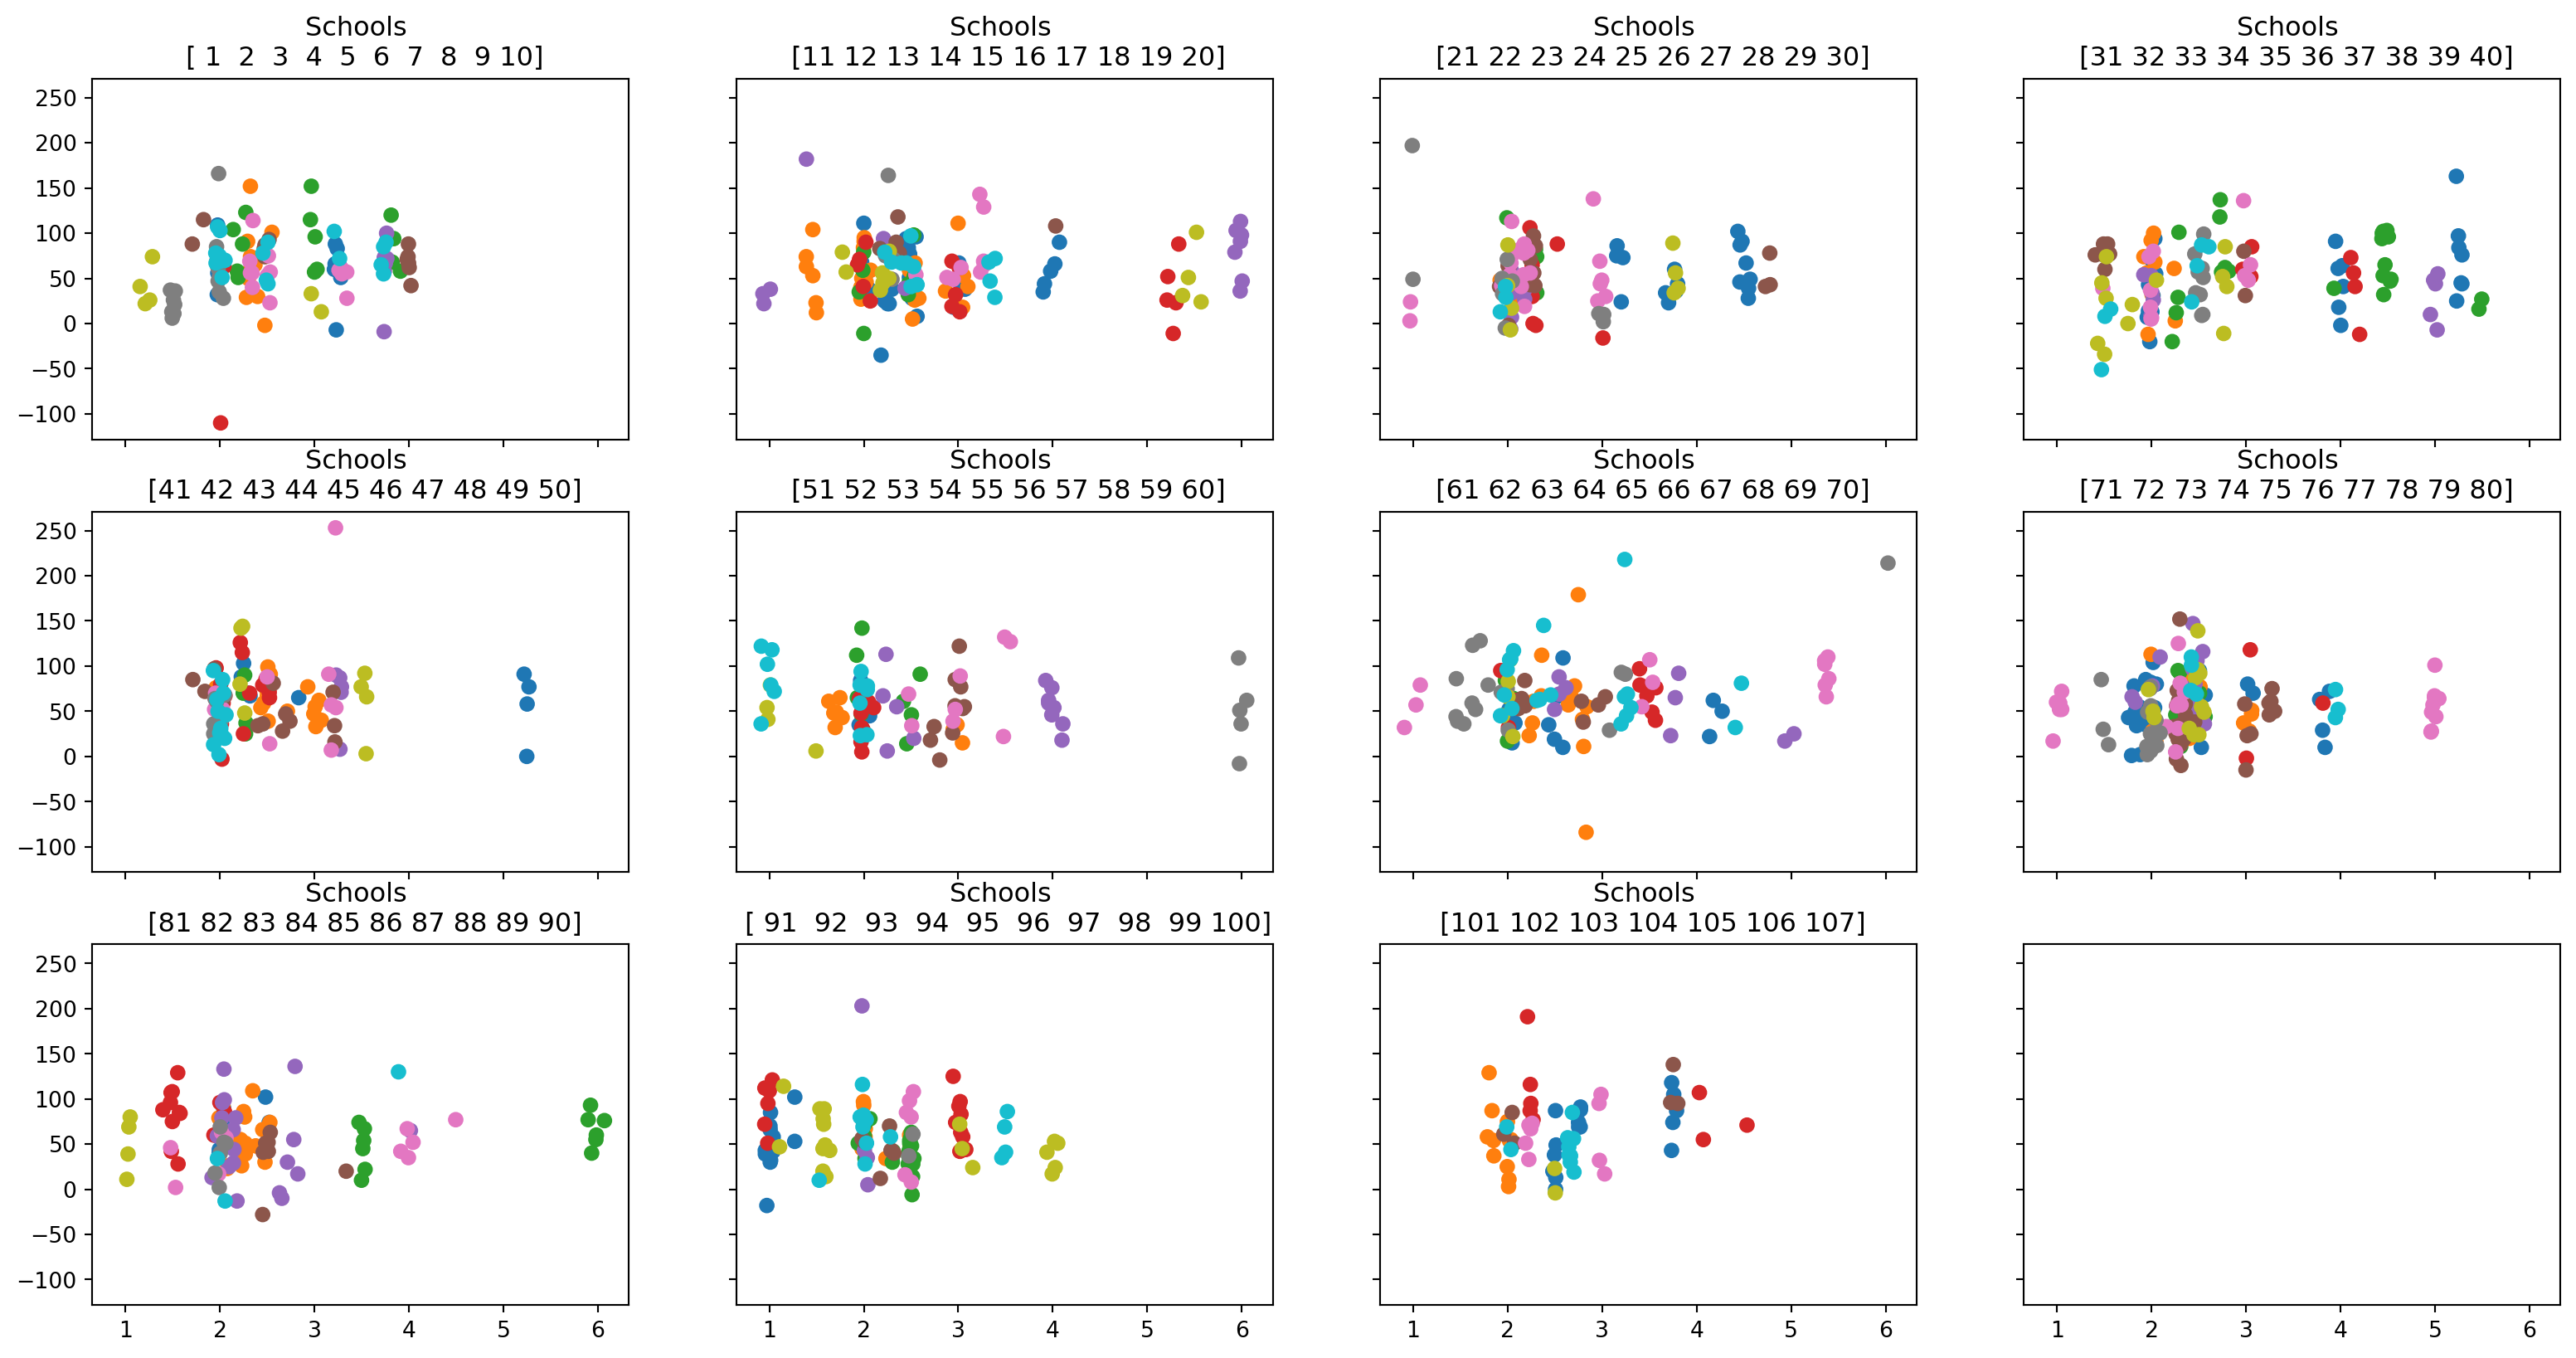

In [18]:
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev


schools = df['schoolid'].unique()
schools_10 = [schools[i:i+10] for i in range(0, len(schools), 10)]
fig, axs = plt.subplots(3,4, figsize=(20, 10), 
sharey=True, sharex=True)
axs = axs.flatten()
for s, ax in zip(schools_10, axs):
    temp = df[df['schoolid'].isin(s)]
    ax.scatter(rand_jitter(temp['mathprep']), temp['mathgain'], 
    c=temp['schoolid'], cmap='tab10')
    ax.set_title(f"Schools \n {s}");


There is a small number of observed students per school so the individual school level distributions show some extreme outliers but the overall distribution nicely converges to an approximately normal symmetric shape.


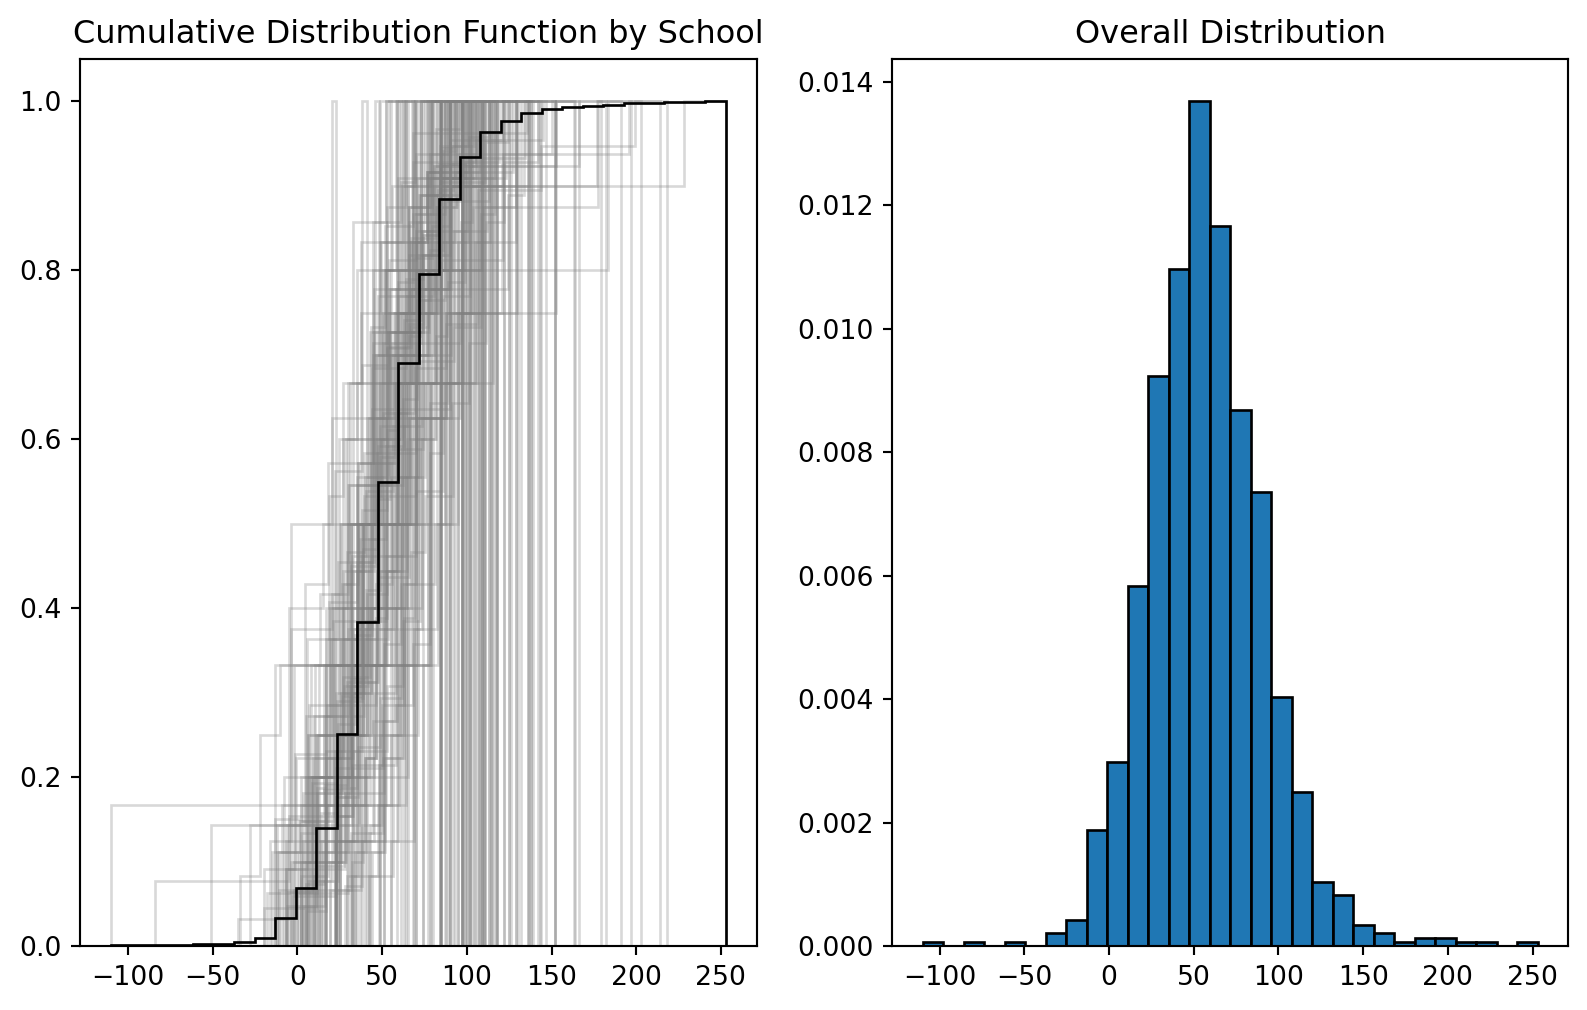

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs = axs.flatten()
for school in schools:
    temp = df[df['schoolid'] ==school]
    axs[0].hist(temp['mathgain'], color='grey', alpha=0.3, density=True, histtype='step', cumulative=True)

axs[0].hist(df['mathgain'], bins=30, ec='black', density=True, cumulative=True, histtype='step')
axs[1].hist(df['mathgain'], bins=30, ec='black', density=True, cumulative=False)
axs[0].set_title("Cumulative Distribution Function by School")
axs[1].set_title("Overall Distribution");

With these kinds of structures we need to be careful in how we evaluate any treatment effects when there are reasons to believe in group-level effects that impact the outcome variable. Imagine the true treatment effect is a sprinter running too fast to cleanly measure - each group interaction effect is added to his load as a weight. Enough weights absorb enough of the variation in the treatment that he is dragged to a crawl. Whatever movement he can make while dragging this burden is the effect we attribute to the treatment. Or put another way - the effects of various group interactions will modify the treatment effectiveness in some way and unless we account for this impact in our model, then the inferences regarding the treatment will be clouded. 

### Interaction Effects and Nuisance Parameters

Not all possible interactions will be present in the data. But if we specify the model to account for various interactions we may explode the number of parameters beyond the number of data points. This can cause issues in estimation routines and requires consideration about what the group parameters are aimed at capturing. 

Why add covariates for group-membership when no observation reflects outcomes in that group? We cannot learn anything about these cases. At least if we add the group effects as a hierarchical random effect we induce shrinkage on the parameter estimates towards the mean of the hierarchical parameter in the model. This means that when predicting on "new" data with examples of these missing cases we can predict a sensible default. The distinction rests in the role we have in mind for these tools. If we seriously commit to the idea that group variation reflects a real "common" process in the larger population and we want to learn about that over-arching process then we deploy a random effects model. But if we only see these as tools for accounting to variation in the sample, allowing us to pin down an alternative focal estimate then the group indicator covariates are just "nuisance" parameters and missing cases are irrelevant.  


::: {.callout-tip}
## Philosophical Digression
This last point skips a little quickly over a fundamental feature of interpreting these models. If we aim to interpret these models as reflecting a common process across these groups that exists in a "population", then we're endorsing an inferential view that extends beyond the sample. We're actively seeking to learn a general truth about the data generating process which we deem to be adequately expressed in our model. If we seek to "soak up" the variation ue to group effects, we're treating these group effects as noise in the sample data and making inferential commitments only about the focal parameter in the model. This approach to learning differentiates approaches to credible causal inference. On the one hand, fixing your estimand and designing estimators to specifically capture that estimate seems like a modest and compelling strategy. On the other hand if your model ignores aspects of underlying phenomena or fails to retrodict the observable data, it's dubious as to why anyone would trust its output. 
:::


To see the extent of this problem we can examine the dimensions of the covariate matrix 


In [20]:
y, X = dmatrices("mathgain ~ mathprep + C(schoolid)+ C(classid)", df, return_type="dataframe")
print(X.shape)

y, X1 = dmatrices("mathgain ~ mathprep + C(schoolid)/C(classid)", df, return_type="dataframe")
print(X1.shape)


y, X2 = dmatrices("mathgain ~ mathprep + C(schoolid):C(childid)", df, return_type="dataframe")
print(X2.shape)

(1190, 419)


(1190, 33385)


(1190, 127331)


We see here how different ways in which to account for group level variation and interaction effects lead to vastly inflated feature matrices. However not all interaction terms matter, or put another way... nor all the possible interactions feature in the data. So we have likely inflated the data matrix beyond necessity. 

Here we define a helper function to parse a complex interaction formula, remove the columns entirely composed of zeros and return a new formula and dataframe which has a suitable range of features to capture the variation structures in the data. 


In [21]:
def make_interactions_df(formula, df):
    y, X = dmatrices(formula, df, return_type="dataframe")
    n = X.shape[1]
    X = X[X.columns[~(np.abs(X) < 1e-12).all()]]
    n1 = X.shape[1]
    target_name = y.columns[0]
    d = pd.concat([y, X], axis=1)
    d.drop(['Intercept'], axis=1, inplace=True)
    d.columns = [c.replace('[', '').replace(']','').replace('C(', '').replace(')', '').replace('.', '_').replace(':', '_') for c in d.columns]
    cols = ' + '.join([col for col in d.columns if col != target_name])
    formula = f"{target_name} ~ {cols}"
    print(f"""Size of original interaction features: {n} \nSize of reduced feature set: {n1}""")
    return formula, d

formula, interaction_df = make_interactions_df("mathgain ~ mathprep + C(schoolid):C(childid)", df)

interaction_df.head()

Size of original interaction features: 127331 
Size of reduced feature set: 2370


mathgain  childidT_2  childidT_3  childidT_4  childidT_5  childidT_6  \
0      32.0         0.0         0.0         0.0         0.0         0.0   
1     109.0         1.0         0.0         0.0         0.0         0.0   
2      56.0         0.0         1.0         0.0         0.0         0.0   
3      83.0         0.0         0.0         1.0         0.0         0.0   
4      53.0         0.0         0.0         0.0         1.0         0.0   

   childidT_7  childidT_8  childidT_9  childidT_10  ...  \
0         0.0         0.0         0.0          0.0  ...   
1         0.0         0.0         0.0          0.0  ...   
2         0.0         0.0         0.0          0.0  ...   
3         0.0         0.0         0.0          0.0  ...   
4         0.0         0.0         0.0          0.0  ...   

   schoolidT_107_childid1182  schoolidT_107_childid1183  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1184  schoolidT_107_childid1185  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1186  schoolidT_107_childid1187  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1188  schoolidT_107_childid1189  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   schoolidT_107_childid1190  mathprep  
0                        0.0      2.00  
1                        0.0      2.00  
2                        0.0      2.00  
3                        0.0      3.25  
4                        0.0      3.25  

[5 rows x 2370 columns]

We have reduced the number of interactions by an order of magnitude! We can now fit a regression model to the revised feature matrix. 

### Comparing Interaction Models

Consider the variation in the coefficient values estimated for `mathprep` as we add more and more interaction effects. The addition of interaction effects generates a large number of completely 0 interaction terms which we remove here. 


In [22]:
formulas = ["""mathgain ~ mathprep + C(schoolid)""",
""" mathgain ~ mathprep + school_mean*class_mean""" , 
"""mathgain ~ mathprep + C(schoolid) + C(classid)""", 
"""mathgain ~ mathprep + C(schoolid)*C(classid)""",
"""mathgain ~ mathprep + C(classid):C(childid)""", 
]

estimates_df = []
for f in formulas:
    formula, interaction_df = make_interactions_df(f, df)
    result = smf.ols(formula, interaction_df).fit()
    estimates = [[result.params['mathprep']], list(result.conf_int().loc['mathprep', :]), [formula]]
    estimates = [e for est in estimates for e in est]
    estimates_df.append(estimates)

estimates_df = pd.DataFrame(estimates_df, columns=['mathprep_estimate', 'lower bound', 'upper bound', 'formula'])

estimates_df

Size of original interaction features: 108 
Size of reduced feature set: 108
Size of original interaction features: 5 
Size of reduced feature set: 5
Size of original interaction features: 419 
Size of reduced feature set: 419


Size of original interaction features: 33385 
Size of reduced feature set: 728


Size of original interaction features: 371281 
Size of reduced feature set: 2376


/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


mathprep_estimate  lower bound  upper bound  \
0           1.060768    -1.435118     3.556655   
1           1.789413    -1.587051     5.165876   
2           2.948546     0.601150     5.295942   
3           3.545931     1.359793     5.732068   
4           2.303187          NaN          NaN   

                                             formula  
0  mathgain ~ schoolidT_2 + schoolidT_3 + schooli...  
1  mathgain ~ mathprep + school_mean + class_mean...  
2  mathgain ~ schoolidT_2 + schoolidT_3 + schooli...  
3  mathgain ~ schoolidT_2 + schoolidT_3 + schooli...  
4  mathgain ~ childidT_2 + childidT_3 + childidT_...

The point here (perhap obvious) is that the estimate of treatment effects due to some policy or programme can be differently understood when the regression model is able to account for increasing aspects of individual variation. Choice of the __right__ way to "saturate" your regression specification are at the heart of causal inference.
We will consider a number of specifications below that incorporate these group effects in a hierarchical model which nests the effect of class-membership within school membership. This choice allows us to control for group specific interactions without worrying about over-indexing on the observed interaction effects in the current data requiring that we handle more fixed effects parameters than we have data points. 

In what follows we'll specify a nested approach to the parameter specifcation using a random effects model. The idea here is that classes are already implicitly nested in schools and so we don't need to add parameters for classes at multiple schools. Additionally we're positing that there is independent interest in the effectiveness school/class effects i.e. the degree to which variation in a school/class nest can account for variation in the outcome. 

#### Minimal Model


In [23]:
#| output: false
#| 
model = bmb.Model(f"mathgain ~ mathprep + (1 | schoolid / classid)", df)
idata = model.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:01.136240


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:06.968196


Transforming variables...


Transformation time = 0:00:03.611822


Computing Log Likelihood...


Log Likelihood time = 0:00:00.411632


The model specification here is deliberately minimalist we want to observe how much of the variation in the outcome can be accounted for by solely adding extensive controls for interactions of group level effects and the treatment but ignoring all else. 


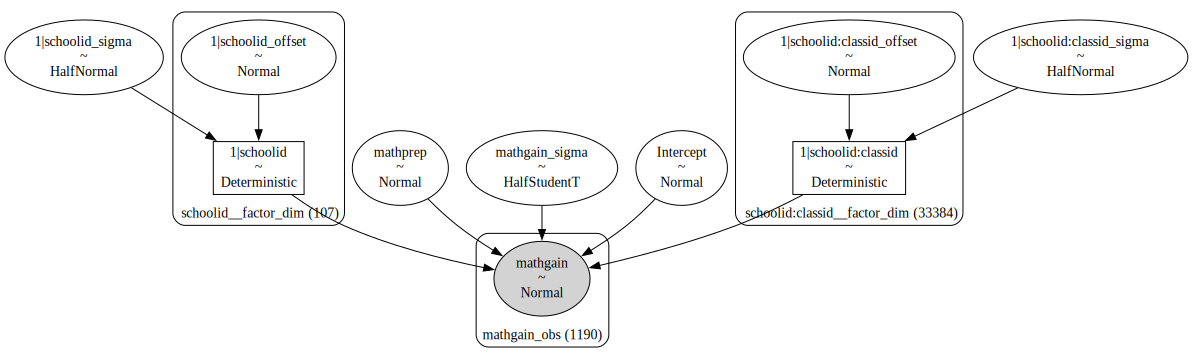

In [24]:
model.graph()

We can see the derived sigma parameters here which can be understood as partialling out the variance of the outcome into components due to those group level effects and the unexplained residuals. 


In [25]:
az.summary(idata, var_names=['Intercept', '1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma', 'mathprep'])


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                 52.498  3.510  46.047   59.212      0.065    0.046   
1|schoolid_sigma           8.528  1.974   4.739   12.145      0.102    0.072   
1|schoolid:classid_sigma   9.898  2.160   5.638   13.796      0.107    0.076   
mathgain_sigma            32.129  0.764  30.661   33.519      0.017    0.012   
mathprep                   1.889  1.240  -0.496    4.105      0.023    0.016   

                          ess_bulk  ess_tail  r_hat  
Intercept                   2893.0    3126.0   1.00  
1|schoolid_sigma             397.0     674.0   1.01  
1|schoolid:classid_sigma     409.0    1046.0   1.01  
mathgain_sigma              2041.0    2676.0   1.00  
mathprep                    2960.0    2833.0   1.00

Note here the relative proportion of the school specifc variances `1|schoolid_sigma` to the overall variance of the residuals `mathgain_sigma`.

### Calculating the IntraClass Correlation Coefficient

These models faciliate the calculation of the ICC statistics which is a measure of "explained variance". The thought is to gauge the proportion of variance ascribed to one set of random effects over and above the total estimated variance in the baseline model, including the residuals `mathgain_sigma`.


In [26]:
a = idata['posterior']['1|schoolid_sigma']**2

b = (idata['posterior']['1|schoolid:classid_sigma']**2 + idata['posterior']['1|schoolid_sigma']**2)

c = (idata['posterior']['1|schoolid:classid_sigma']**2 + idata['posterior']['1|schoolid_sigma']**2 + idata['posterior']['mathgain_sigma']**2)

(a / c).mean().item() 


0.06293874174271491

In [27]:
((a + b) / c).mean().item()

0.21029894892537912

We can see here that the interaction terms do seem to account for a goodly portion of the variance in the outcome and we ought to consider retaining their inclusion in our modelling work. The structure of the problem drives us towards their inclusion. Class/school effects are going to absorb a sufficient portion of the variation. So they merit study in their own right, lest the individual class/school dynamics obscure the effectiveness of the `mathprep` treatment. Similarly, it's likely valuable to consider the efficacy of the average class/school in a wider policy conversation. 

### Augmenting the Models

Next we augment our model with more pupil level control variables aiming to pin down some of the aspects of the variation in the outcome. 

#### Adding Pupil Fixed Effects


In [28]:
#| output: false

model_fixed = bmb.Model(f"mathgain ~ mathkind + sex + minority + ses + mathprep + (1 | schoolid / classid)", df)
idata_fixed = model_fixed.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:01.010781


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:18:11.944773


Transforming variables...


Transformation time = 0:00:03.285857


Computing Log Likelihood...


Log Likelihood time = 0:00:00.440509


In [29]:
az.summary(idata_fixed, var_names=['Intercept', 
'mathkind', 'sex', 'minority', 'ses', 'mathprep',
'1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma'])

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
Intercept                 280.372  11.570  258.399  302.049      0.202   
mathkind                   -0.469   0.023   -0.508   -0.422      0.000   
sex                        -1.271   1.614   -4.384    1.627      0.025   
minority                   -8.235   2.296  -12.732   -4.132      0.042   
ses                         5.392   1.243    3.049    7.690      0.020   
mathprep                    0.808   1.084   -1.140    2.837      0.022   
1|schoolid_sigma            8.695   1.607    5.776   11.788      0.058   
1|schoolid:classid_sigma    8.999   1.759    5.438   12.053      0.075   
mathgain_sigma             27.189   0.646   26.007   28.434      0.015   

                          mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                   0.144    3285.0    2831.0   1.00  
mathkind                    0.000    3358.0    2683.0   1.00  
sex                         0.022    4013.0    3005.0   1.00  
minority                    0.030    2964.0    3036.0   1.00  
ses                         0.014    3977.0    3404.0   1.00  
mathprep                    0.016    2475.0    2850.0   1.00  
1|schoolid_sigma            0.041     792.0     934.0   1.01  
1|schoolid:classid_sigma    0.053     574.0     764.0   1.00  
mathgain_sigma              0.010    1974.0    2724.0   1.00

Now we add a further class level control. 

#### Adding Class Level Fixed Effects


In [30]:
#| output: false

model_fixed_1 = bmb.Model(f"mathgain ~ mathkind + sex + minority + ses + yearstea +	mathknow + mathprep + (1 | schoolid / classid)", df.dropna())
idata_fixed_1 = model_fixed_1.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:02.052161


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:17.265078


Transforming variables...


Transformation time = 0:00:02.600855


Computing Log Likelihood...


Log Likelihood time = 0:00:00.411288


In [31]:
az.summary(idata_fixed_1, var_names=['Intercept', 
'mathkind', 'sex', 'minority', 'ses', 'yearstea', 'mathknow', 'mathprep','1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma'])

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
Intercept                 281.756  11.830  260.880  304.530      0.171   
mathkind                   -0.475   0.023   -0.518   -0.433      0.000   
sex                        -1.331   1.674   -4.560    1.742      0.022   
minority                   -7.874   2.451  -12.385   -3.232      0.041   
ses                         5.427   1.266    2.973    7.737      0.020   
yearstea                    0.041   0.121   -0.191    0.265      0.002   
mathknow                    1.898   1.169   -0.470    3.960      0.023   
mathprep                    1.102   1.164   -1.121    3.200      0.021   
1|schoolid_sigma            8.616   1.758    4.950   11.645      0.070   
1|schoolid:classid_sigma    9.340   1.826    5.958   12.699      0.076   
mathgain_sigma             26.764   0.658   25.580   28.059      0.014   

                          mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                   0.121    4819.0    2987.0   1.00  
mathkind                    0.000    4998.0    2874.0   1.00  
sex                         0.022    5754.0    2649.0   1.00  
minority                    0.029    3588.0    2593.0   1.00  
ses                         0.015    3907.0    2712.0   1.00  
yearstea                    0.002    3003.0    2737.0   1.00  
mathknow                    0.016    2677.0    2838.0   1.00  
mathprep                    0.015    3192.0    2914.0   1.00  
1|schoolid_sigma            0.050     640.0     986.0   1.01  
1|schoolid:classid_sigma    0.054     610.0     779.0   1.01  
mathgain_sigma              0.010    2186.0    2530.0   1.00

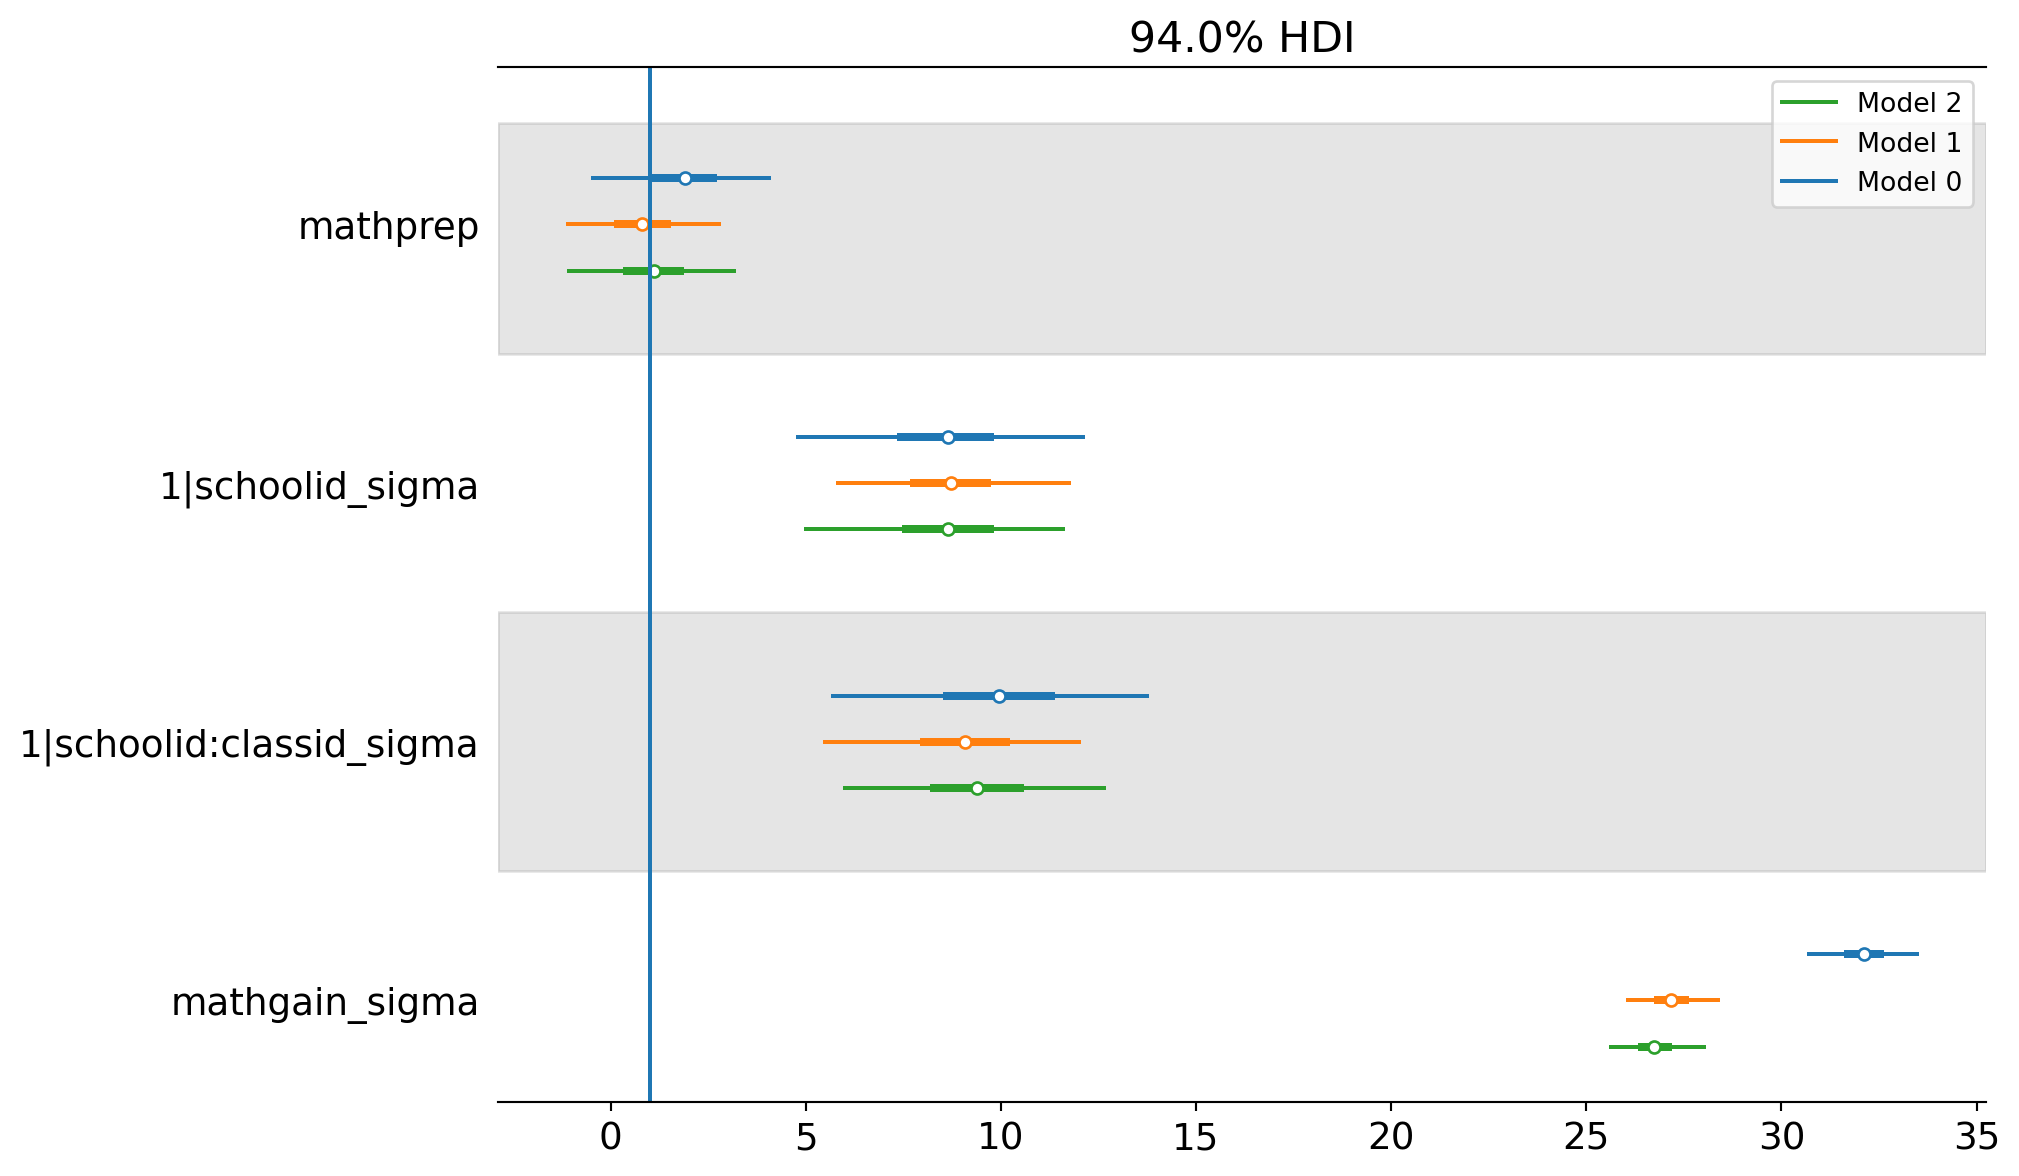

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))
az.plot_forest([idata, idata_fixed, idata_fixed_1], combined=True, var_names=['mathprep', '1|schoolid_sigma', '1|schoolid:classid_sigma', 'mathgain_sigma'], ax=ax)
ax.axvline(1)

We now make use of `bambi`s model interpretation module to plot the marginal effect on the outcome due to changes in the treatment intensity. 


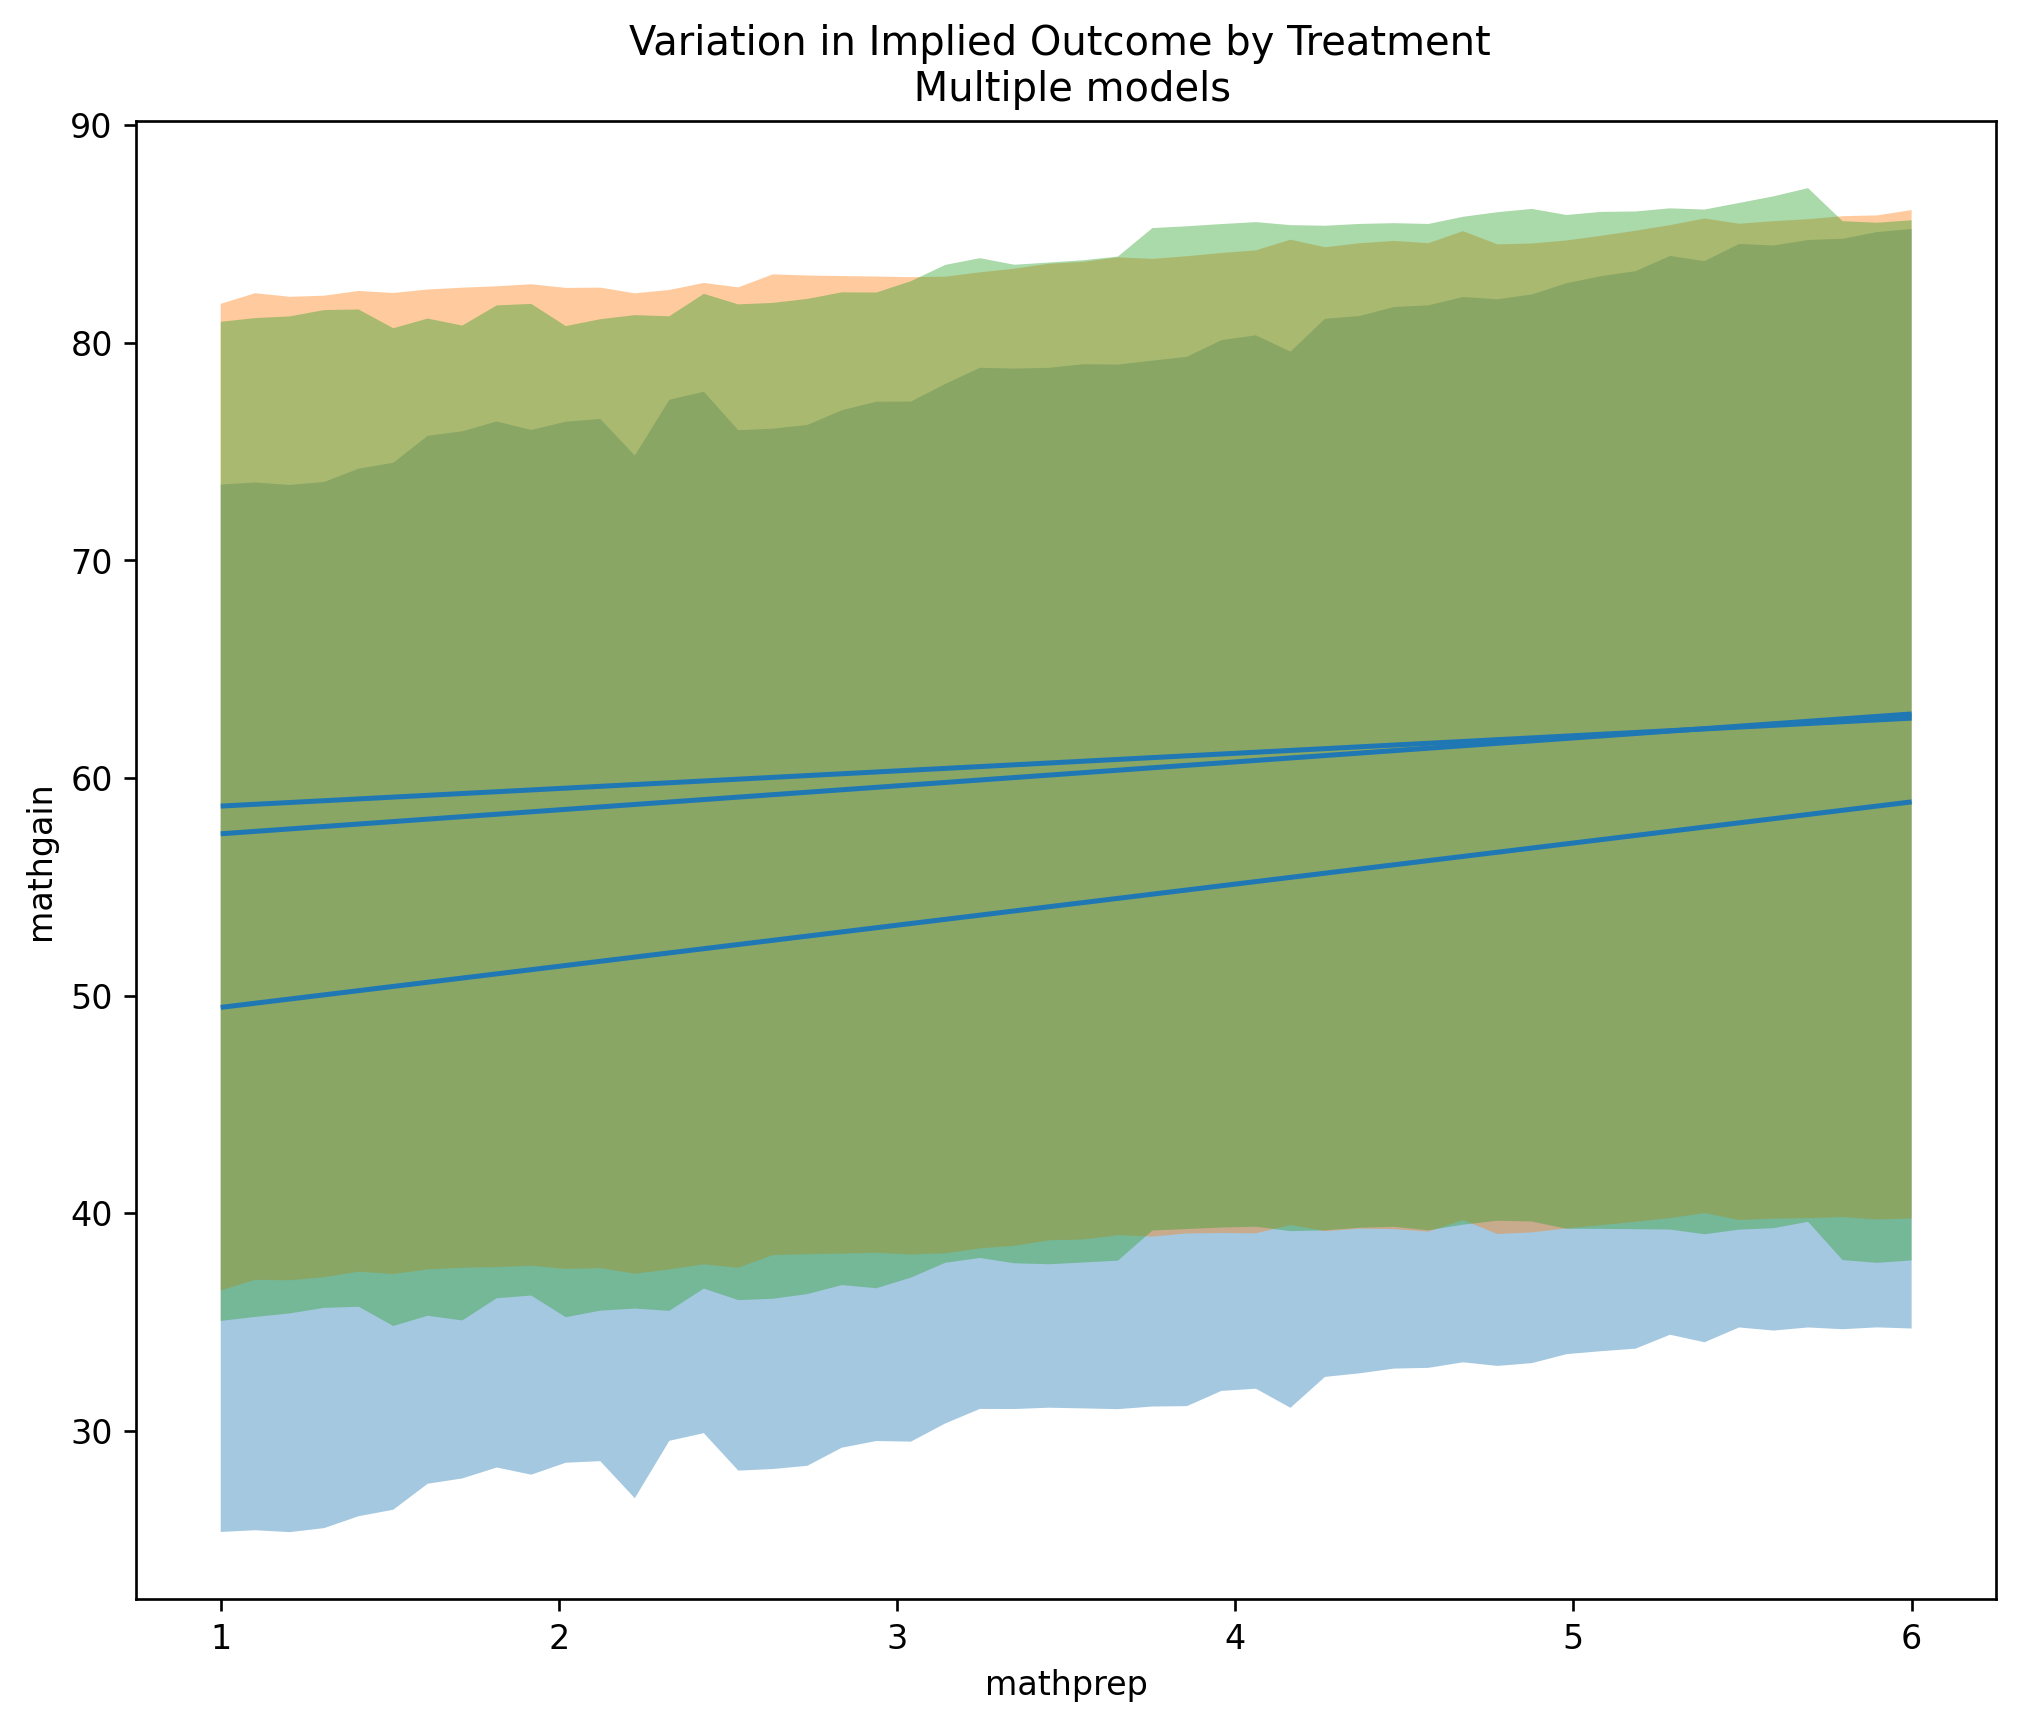

In [33]:
fig, ax = plt.subplots(figsize=(10, 8), 
dpi=120, sharey=True, sharex=True)
bmb.interpret.plot_predictions(model, idata, "mathprep", ax=ax);
bmb.interpret.plot_predictions(model_fixed, idata_fixed, "mathprep", ax=ax);
bmb.interpret.plot_predictions(model_fixed_1, idata_fixed_1, "mathprep", ax=ax);
ax.set_title("Variation in Implied Outcome by Treatment \n Multiple models");


As we can see here across all the different model specifications we see modest effects of treatment with very wide uncertainty. So far, so what?! You might be sceptical that teacher training has any real discernible impact on child outcomes? Maybe you believe other interventions are more important to fund? 

These kinds of questions determine policy. Misguided policy interventions on child-hood education can have radical consequences for the children. It's, therefore, vital that we have robust and justifiable approaches to the analysis of these policy questions in the face of group level confounding.  

## Two Way Fixed Effects and Temporal Confounding

Difference in Differences designs are the overworked donkeys of social science. Many, many studies stand or fall by the assumptions baked into DiD designs. There are at least two aspects to these assumptions (i) the substantive commitments about the data generating process and (ii) the appropriateness of the functional form used to model (i). We will look first at a case where all the assumptions can be met, and then examine how things break-down. 

### Event Studies and Change in Time

We take this panel data set from the `pyfixest`.


In [34]:
url = "https://raw.githubusercontent.com/py-econometrics/pyfixest/master/pyfixest/did/data/df_het.csv"
df_het = pd.read_csv(url)
df_het.head()

unit  state    group   unit_fe     g  year   year_fe  treat  rel_year  \
0     1     33  Group 2  7.043016  2010  1990  0.066159  False     -20.0   
1     1     33  Group 2  7.043016  2010  1991 -0.030980  False     -19.0   
2     1     33  Group 2  7.043016  2010  1992 -0.119607  False     -18.0   
3     1     33  Group 2  7.043016  2010  1993  0.126321  False     -17.0   
4     1     33  Group 2  7.043016  2010  1994 -0.106921  False     -16.0   

   rel_year_binned     error  te  te_dynamic   dep_var  
0               -6 -0.086466   0         0.0  7.022709  
1               -6  0.766593   0         0.0  7.778628  
2               -6  1.512968   0         0.0  8.436377  
3               -6  0.021870   0         0.0  7.191207  
4               -6 -0.017603   0         0.0  6.918492

Panel data of this kind is difficulty to envisage unless visualised.


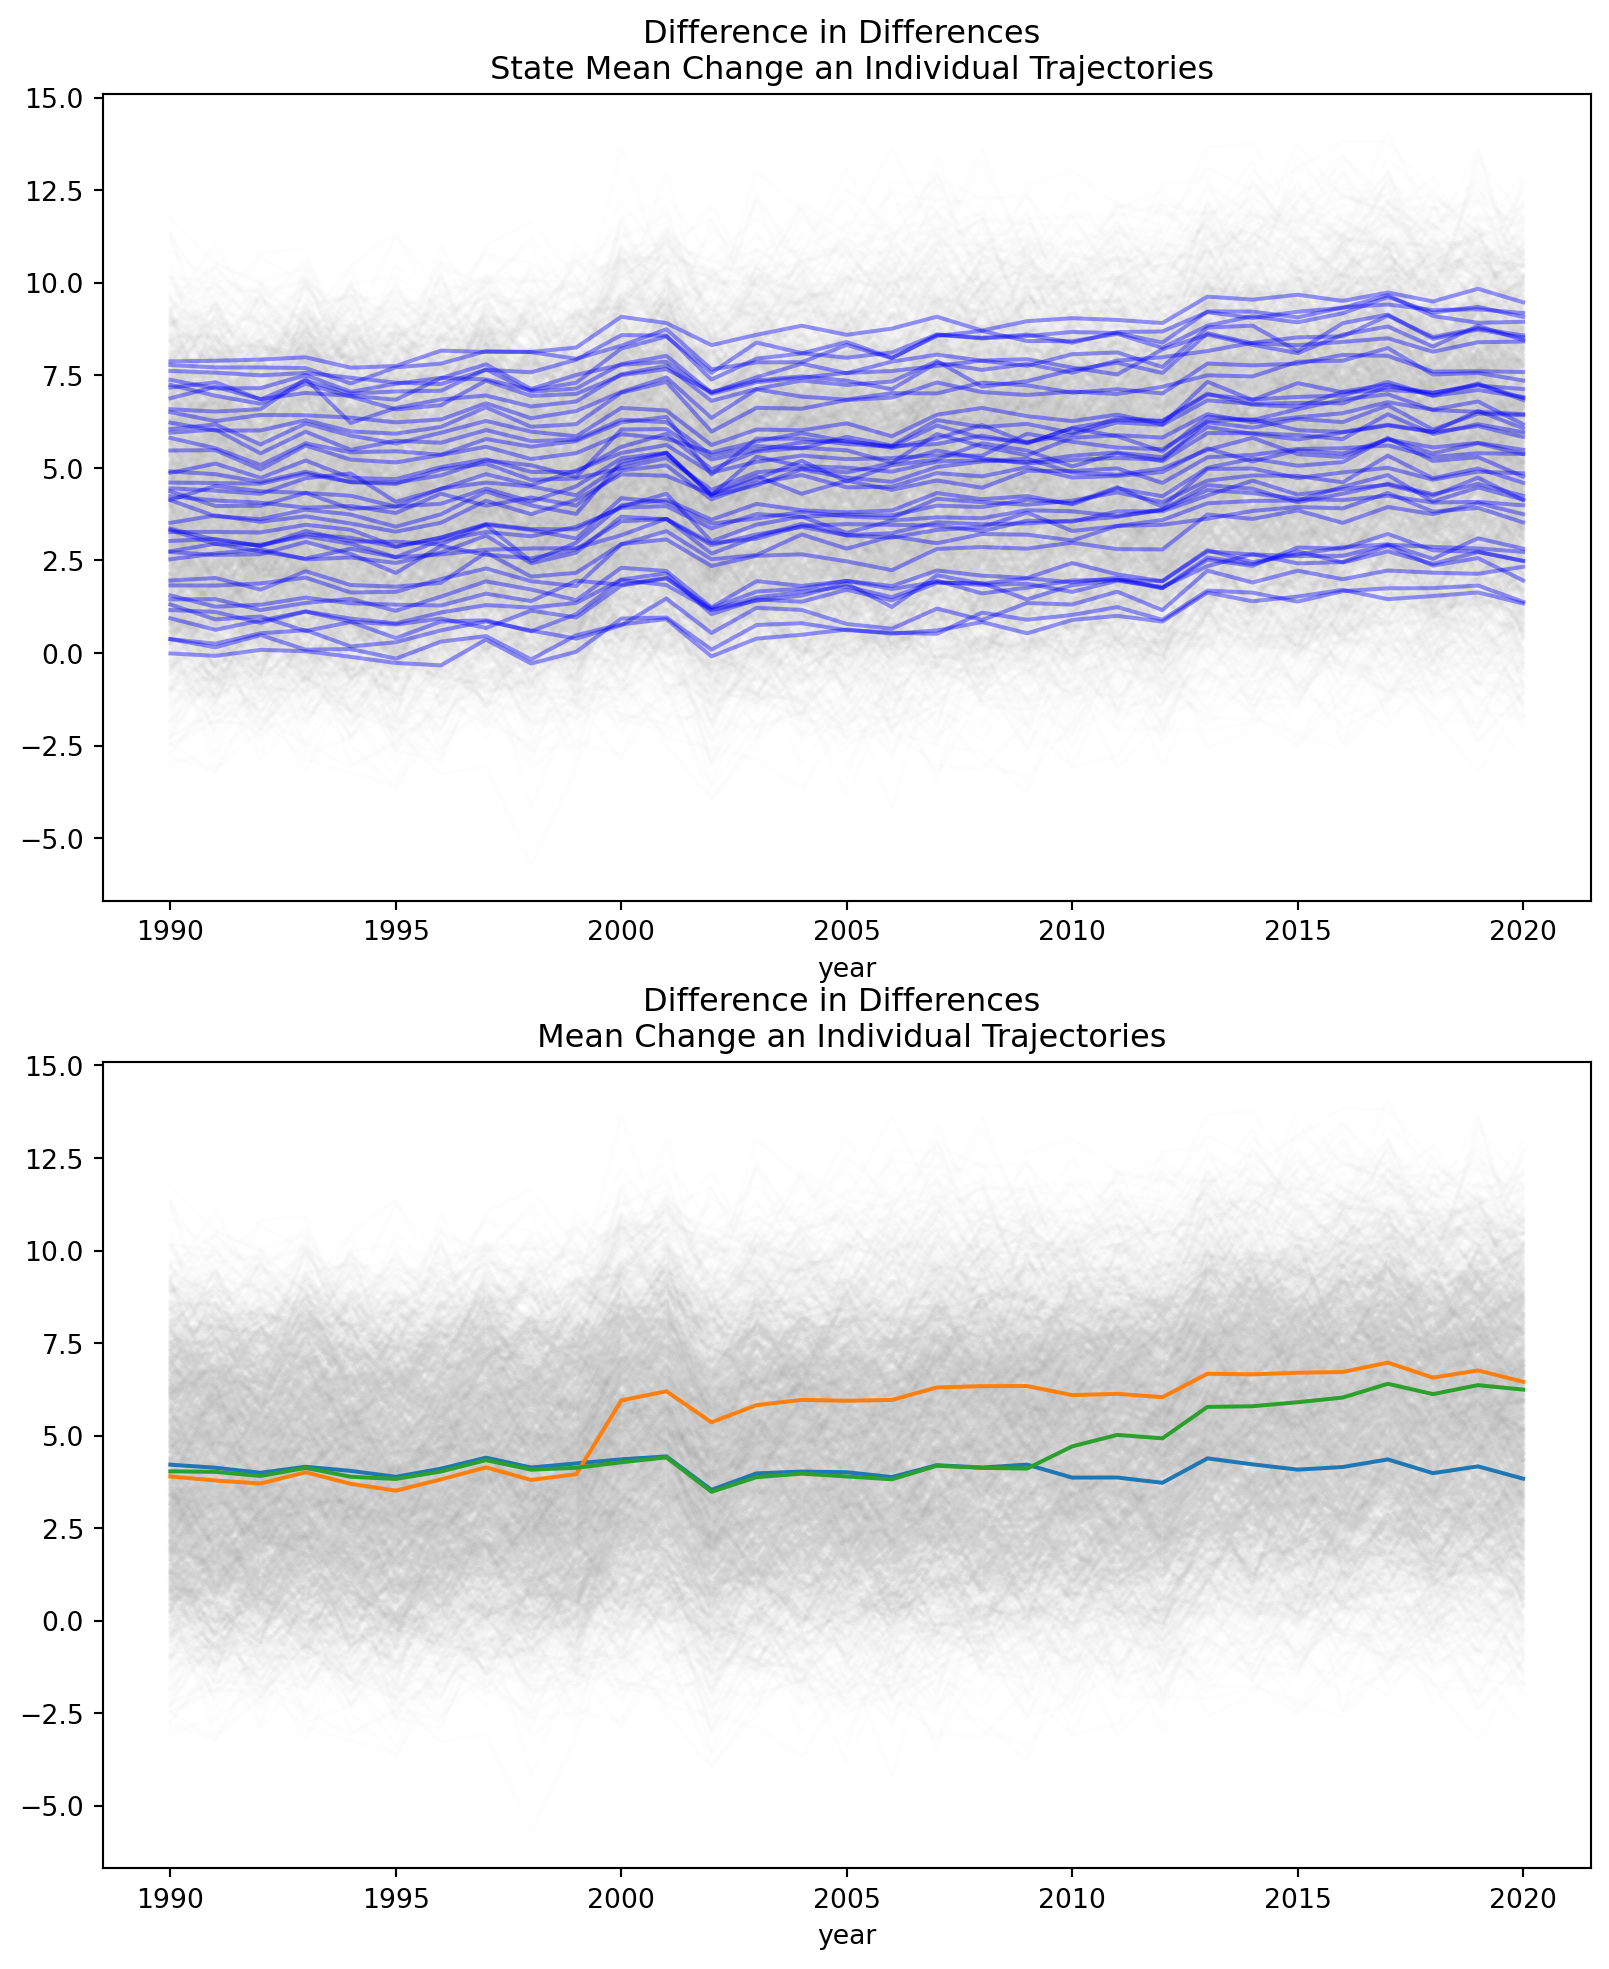

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))
axs = axs.flatten()
for u in df_het['unit'].unique():
    temp = df_het[df_het['unit']==u]
    axs[0].plot(temp['year'], temp['dep_var'], color='grey', alpha=0.01)
    axs[1].plot(temp['year'], temp['dep_var'], color='grey', alpha=0.01)
df_het.groupby(['year', 'state'])[['dep_var']].mean().reset_index().pivot(index='year', columns='state', values='dep_var').plot(ax=axs[0], legend=False, color='blue', 
alpha=0.4)

df_het.groupby(['year', 'g'])[['dep_var']].mean().reset_index().pivot(index='year', columns='g', values='dep_var').plot(ax=axs[1], legend=False)

axs[0].set_title("Difference in Differences \n State Mean Change an Individual Trajectories")
axs[1].set_title("Difference in Differences \n Mean Change an Individual Trajectories");

Note how the blue line represents a cohort that never undergoes a treatment and is maintained as a coherent control group throughout the sequence even though we have two other cohorts. 

### TWFE in `pyfixest`

A natural way to interrogate these kinds of question is to wonder how the treatment effect evolves over time. Is it initially impactful with with quick plateau or a slowly building pattern of consistent growth?


In [36]:
fit_twfe_event = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year ",
    df_het,
    vcov={"CRV1": "state"},
)

fit_twfe_event.tidy()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimate  Std. Error  \
Coefficient                                                              
C(rel_year, contr.treatment(base=-1.0))[T.-20.0] -0.099445    0.081699   
C(rel_year, contr.treatment(base=-1.0))[T.-19.0]  0.000624    0.083213   
C(rel_year, contr.treatment(base=-1.0))[T.-18.0]  0.004125    0.089719   
C(rel_year, contr.treatment(base=-1.0))[T.-17.0]  0.021899    0.085686   
C(rel_year, contr.treatment(base=-1.0))[T.-16.0] -0.036933    0.096921   
C(rel_year, contr.treatment(base=-1.0))[T.-15.0]  0.069578    0.081289   
C(rel_year, contr.treatment(base=-1.0))[T.-14.0]  0.037734    0.086618   
C(rel_year, contr.treatment(base=-1.0))[T.-13.0]  0.061779    0.083362   
C(rel_year, contr.treatment(base=-1.0))[T.-12.0]  0.089913    0.084900   
C(rel_year, contr.treatment(base=-1.0))[T.-11.0]  0.000982    0.079104   
C(rel_year, contr.treatment(base=-1.0))[T.-10.0] -0.113033    0.064922   
C(rel_year, contr.treatment(base=-1.0))[T.-9.0]  -0.069225    0.057046   
C(rel_year, contr.treatment(base=-1.0))[T.-8.0]  -0.061290    0.060362   
C(rel_year, contr.treatment(base=-1.0))[T.-7.0]  -0.002022    0.064602   
C(rel_year, contr.treatment(base=-1.0))[T.-6.0]  -0.055810    0.064674   
C(rel_year, contr.treatment(base=-1.0))[T.-5.0]  -0.065009    0.064810   
C(rel_year, contr.treatment(base=-1.0))[T.-4.0]  -0.009850    0.053098   
C(rel_year, contr.treatment(base=-1.0))[T.-3.0]   0.046338    0.062950   
C(rel_year, contr.treatment(base=-1.0))[T.-2.0]   0.015947    0.065442   
C(rel_year, contr.treatment(base=-1.0))[T.0.0]    1.406404    0.055641   
C(rel_year, contr.treatment(base=-1.0))[T.1.0]    1.660552    0.065033   
C(rel_year, contr.treatment(base=-1.0))[T.2.0]    1.728790    0.056793   
C(rel_year, contr.treatment(base=-1.0))[T.3.0]    1.854839    0.058315   
C(rel_year, contr.treatment(base=-1.0))[T.4.0]    1.958676    0.071144   
C(rel_year, contr.treatment(base=-1.0))[T.5.0]    2.082161    0.063855   
C(rel_year, contr.treatment(base=-1.0))[T.6.0]    2.191062    0.068510   
C(rel_year, contr.treatment(base=-1.0))[T.7.0]    2.279073    0.075014   
C(rel_year, contr.treatment(base=-1.0))[T.8.0]    2.364593    0.058598   
C(rel_year, contr.treatment(base=-1.0))[T.9.0]    2.372163    0.056560   
C(rel_year, contr.treatment(base=-1.0))[T.10.0]   2.649271    0.056177   
C(rel_year, contr.treatment(base=-1.0))[T.11.0]   2.753591    0.075526   
C(rel_year, contr.treatment(base=-1.0))[T.12.0]   2.813935    0.079320   
C(rel_year, contr.treatment(base=-1.0))[T.13.0]   2.756070    0.078368   
C(rel_year, contr.treatment(base=-1.0))[T.14.0]   2.863427    0.098389   
C(rel_year, contr.treatment(base=-1.0))[T.15.0]   2.986652    0.093309   
C(rel_year, contr.treatment(base=-1.0))[T.16.0]   2.963032    0.085427   
C(rel_year, contr.treatment(base=-1.0))[T.17.0]   2.972596    0.092390   
C(rel_year, contr.treatment(base=-1.0))[T.18.0]   2.935051    0.094126   
C(rel_year, contr.treatment(base=-1.0))[T.19.0]   2.918707    0.084193   
C(rel_year, contr.treatment(base=-1.0))[T.20.0]   2.979701    0.087777   
C(rel_year, contr.treatment(base=-1.0))[T.inf]    0.128053    0.078513   

                                                    t value  Pr(>|t|)  \
Coefficient                                                             
C(rel_year, contr.treatment(base=-1.0))[T.-20.0]  -1.217202  0.230842   
C(rel_year, contr.treatment(base=-1.0))[T.-19.0]   0.007493  0.994060   
C(rel_year, contr.treatment(base=-1.0))[T.-18.0]   0.045974  0.963565   
C(rel_year, contr.treatment(base=-1.0))[T.-17.0]   0.255573  0.799624   
C(rel_year, contr.treatment(base=-1.0))[T.-16.0]  -0.381067  0.705221   
C(rel_year, contr.treatment(base=-1.0))[T.-15.0]   0.855936  0.397262   
C(rel_year, contr.treatment(base=-1.0))[T.-14.0]   0.435641  0.665499   
C(rel_year, contr.treatment(base=-1.0))[T.-13.0]   0.741098  0.463073   
C(rel_year, contr.treatment(base=-1.0))[T.-12.0]   1.059044  0.296095   
C(rel_year, contr.treatment(base=-1.0))[T.-11.0]   0.012417  0.9

The model specification defines indicator variables for the relative years before and after the penultimate year before treatment is applied, it then includes the fixed effects for state and year indicators. The coefficient values ascribed the the relative year indicators are used to plot the event-study trajectories. This is a two-way fixed effects estimation routine where the fixed effects for state and year indicators absorb the variance due to those groupings. 


In [37]:
figsize = [1200, 900]
fit_twfe_event.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
).show()


We can also aim to marginalise over the details of the state trajectories by defining the similar estimation routine on the individuals and their treatment indicator. 


In [38]:
fit_twfe = pf.feols(
    "dep_var ~ i(treat) | unit + year",
    df_het,
    vcov={"CRV1": "state"},
)

fit_twfe.tidy()


Estimate  Std. Error    t value  Pr(>|t|)      2.5%  \
Coefficient                                                             
C(treat)[T.True]   1.98254    0.019331  102.55618       0.0  1.943439   

                     97.5%  
Coefficient                 
C(treat)[T.True]  2.021642

### De-meaning and TWFEs

We've seen above that the fixed-effect estimators in these DiD designs involve a lot of indicator variables. These are largely not the focus on the question at hand but are used exlusively to absorb the noise that takes away from our understanding of the treatment effect. We can achieve similar results with less parameters required if we "de-mean" the focus variables by the group averages of the control factors of `state` and `year` or `unit`. This operation makes for more efficient TWFE estimation routines is [provably](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3906345) a variety of mundlak regression as shown by Woolridge 2021. 

We implement the de-meaning technique and show "equivalence by python" as follows:

In [39]:
def demean(df, col_to_demean, group):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby(group)[col_to_demean].transform("mean")
                                        )})


def apply_demeaning(df_het, by=['state', 'year'], event=True):
    if event: 
        d = pd.get_dummies(df_het['rel_year']).drop(-1, axis=1) 
        d.columns = ['rel_year_' +str(c).replace('-', 'minus_') for c in d.columns]
    else:
        d = df_het[['treat']]
    d[by[0]] = df_het[by[0]]
    d[by[1]] = df_het[by[1]]
    for col in d.columns: 
        if col in by:
            pass
        else: 
            for c in by:
                d = demean(d, col, c)
    d = d.drop(by, axis=1)
    d['dep_var'] = df_het['dep_var']
    return d
## Demean the relative years features for event studies
d_event = apply_demeaning(df_het, by=['state', 'year'], event=True)

## Demean the treatment indicator for ATT estimation
d = apply_demeaning(df_het, by=['unit', 'year'], event=False)

d_event.head()

rel_year_minus_20.0  rel_year_minus_19.0  rel_year_minus_18.0  \
0             0.651694            -0.002973            -0.002973   
1            -0.002973             0.651694            -0.002973   
2            -0.002973            -0.002973             0.651694   
3            -0.002973            -0.002973            -0.002973   
4            -0.002973            -0.002973            -0.002973   

   rel_year_minus_17.0  rel_year_minus_16.0  rel_year_minus_15.0  \
0            -0.002973            -0.002973            -0.002973   
1            -0.002973            -0.002973            -0.002973   
2            -0.002973            -0.002973            -0.002973   
3             0.651694            -0.002973            -0.002973   
4            -0.002973             0.651694            -0.002973   

   rel_year_minus_14.0  rel_year_minus_13.0  rel_year_minus_12.0  \
0            -0.002973            -0.002973            -0.002973   
1            -0.002973            -0.002973            -0.002973   
2            -0.002973            -0.002973            -0.002973   
3            -0.002973            -0.002973            -0.002973   
4            -0.002973            -0.002973            -0.002973   

   rel_year_minus_11.0  ...  rel_year_13.0  rel_year_14.0  rel_year_15.0  \
0            -0.002973  ...       0.000734       0.000734       0.000734   
1            -0.002973  ...       0.000734       0.000734       0.000734   
2            -0.002973  ...       0.000734       0.000734       0.000734   
3            -0.002973  ...       0.000734       0.000734       0.000734   
4            -0.002973  ...       0.000734       0.000734       0.000734   

   rel_year_16.0  rel_year_17.0  rel_year_18.0  rel_year_19.0  rel_year_20.0  \
0       0.000734       0.000734       0.000734       0.000734       0.000734   
1       0.000734       0.000734       0.000734       0.000734       0.000734   
2       0.000734       0.000734       0.000734       0.000734       0.000734   
3       0.000734       0.000734       0.000734       0.000734       0.000734   
4       0.000734       0.000734       0.000734       0.000734       0.000734   

   rel_year_inf   dep_var  
0      -0.28125  7.022709  
1      -0.28125  7.778628  
2      -0.28125  8.436377  
3      -0.28125  7.191207  
4      -0.28125  6.918492  

[5 rows x 42 columns]

We now have a data set with 42 columns focused on the treatment structures, but implicitly controls for the variation due to state and time. We'll see below that this representation of the data will correctly estimate the treatment effects. 

### Event Study and De-Meaning
Now we'll use the de-meaned data structure above to estimate an event study using `Bambi`. 


In [40]:
#| output: false
#| 
x_cols = ' + '.join([c for c in d_event.columns if c != 'dep_var'])
model_twfe_event = bmb.Model(f"dep_var ~ + {x_cols}", d_event)
idata_twfe_event = model_twfe_event.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)


Compiling...


Compilation time = 0:00:02.664319


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:55.117588


Transforming variables...


Transformation time = 0:00:00.258617


Computing Log Likelihood...


Log Likelihood time = 0:00:01.009043


In [41]:
model_twfe_event

       Formula: dep_var ~ + rel_year_minus_20.0 + rel_year_minus_19.0 + rel_year_minus_18.0 + rel_year_minus_17.0 + rel_year_minus_16.0 + rel_year_minus_15.0 + rel_year_minus_14.0 + rel_year_minus_13.0 + rel_year_minus_12.0 + rel_year_minus_11.0 + rel_year_minus_10.0 + rel_year_minus_9.0 + rel_year_minus_8.0 + rel_year_minus_7.0 + rel_year_minus_6.0 + rel_year_minus_5.0 + rel_year_minus_4.0 + rel_year_minus_3.0 + rel_year_minus_2.0 + rel_year_0.0 + rel_year_1.0 + rel_year_2.0 + rel_year_3.0 + rel_year_4.0 + rel_year_5.0 + rel_year_6.0 + rel_year_7.0 + rel_year_8.0 + rel_year_9.0 + rel_year_10.0 + rel_year_11.0 + rel_year_12.0 + rel_year_13.0 + rel_year_14.0 + rel_year_15.0 + rel_year_16.0 + rel_year_17.0 + rel_year_18.0 + rel_year_19.0 + rel_year_20.0 + rel_year_inf
        Family: gaussian
          Link: mu = identity
  Observations: 46500
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.7062, sigma: 7.1549)
            rel_year_minus

We can then plot the event-study and observe a similar pattern to the one observed with `pyfixest`. 


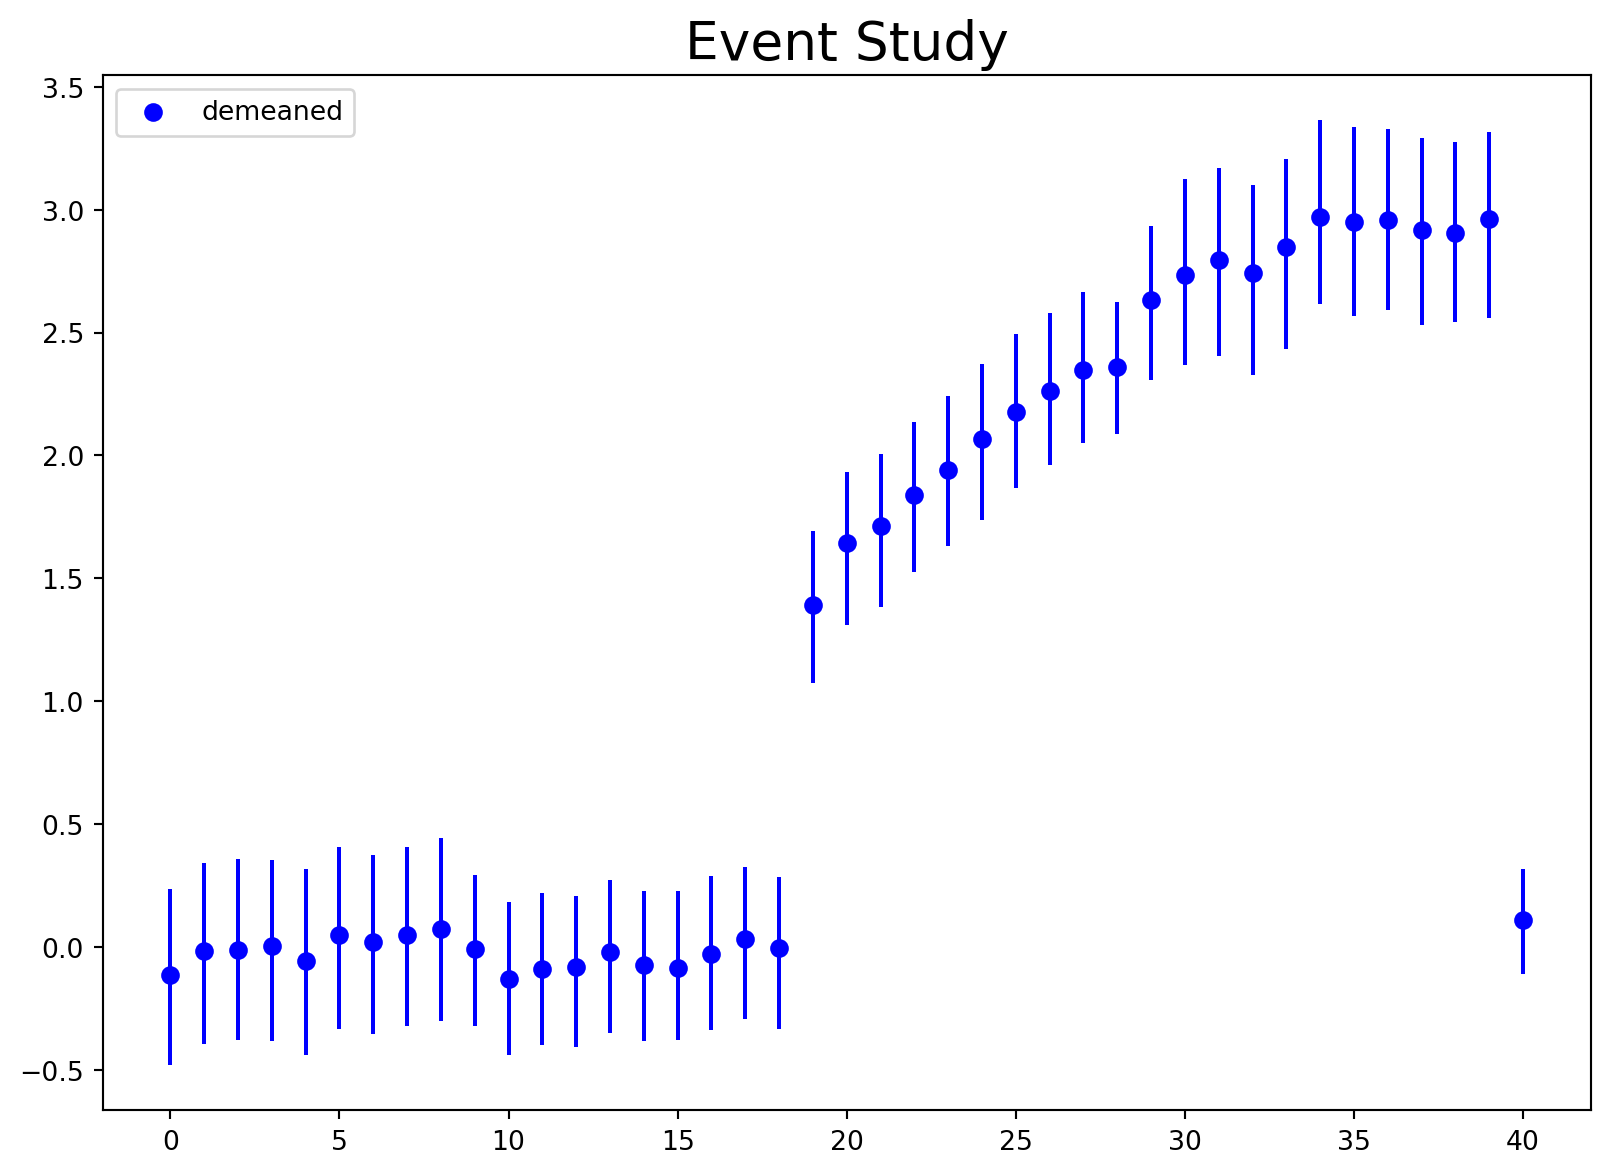

In [42]:
def plot_event_study(idata, ax, color='blue', model='demeaned'):
    summary_df = az.summary(idata)
    cols = [i for i in summary_df.index if 'rel' in i]
    summary_df = summary_df[summary_df.index.isin(cols)]
    x = range(len(summary_df))
    ax.scatter(x, summary_df['mean'], label=model, color=color)
    ax.plot([x, x], [summary_df['hdi_3%'],summary_df['hdi_97%']],   color=color)
    ax.set_title("Event Study", fontsize=20)
    return ax

fig, ax = plt.subplots(figsize=(10, 7))
plot_event_study(idata_twfe_event, ax)
ax.legend()

Similarly, we can de-mean the simple treatment indicator using the group means and marginalise over time periods to find a single treatment effect estimate. 


In [43]:
#| output: false

model_twfe_trt_demean = bmb.Model(f"dep_var ~ treat", d)
idata_twfe_trt_demean = model_twfe_trt_demean.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)


Compiling...


Compilation time = 0:00:00.445059


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.719975


Transforming variables...


Transformation time = 0:00:00.034210


Computing Log Likelihood...


Log Likelihood time = 0:00:00.420871


In [44]:
az.summary(idata_twfe_trt_demean)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept      4.706  0.013   4.681    4.730      0.000    0.000    2765.0   
treat          1.983  0.049   1.890    2.071      0.001    0.001    3219.0   
dep_var_sigma  2.811  0.009   2.793    2.828      0.000    0.000    4571.0   

               ess_tail  r_hat  
Intercept        2323.0    1.0  
treat            2420.0    1.0  
dep_var_sigma    2873.0    1.0

Which again accords with the reported values from `pyfixest`. This is equivalent to using a Mundlak device as we can see below: 

### TWFE by Mundlak Device


In [45]:
#| output: false

df_het['unit_mean'] = df_het.groupby('unit')['treat'].transform(np.mean)
df_het['time_mean'] = df_het.groupby('year')['treat'].transform(np.mean)

model_twfe_trt = bmb.Model(f"dep_var ~ treat", df_het)
idata_twfe_trt = model_twfe_trt.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

model_twfe_trt_mundlak = bmb.Model(f"dep_var ~ treat + unit_mean + time_mean", df_het)
idata_twfe_trt_mundlak = model_twfe_trt_mundlak.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True},)

Compiling...


Compilation time = 0:00:00.440198


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.523451


Transforming variables...


Transformation time = 0:00:00.033256


Computing Log Likelihood...


Log Likelihood time = 0:00:02.339827


Compiling...


Compilation time = 0:00:00.560133


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:05.755999


Transforming variables...


Transformation time = 0:00:00.044054


Computing Log Likelihood...


Log Likelihood time = 0:00:01.370108


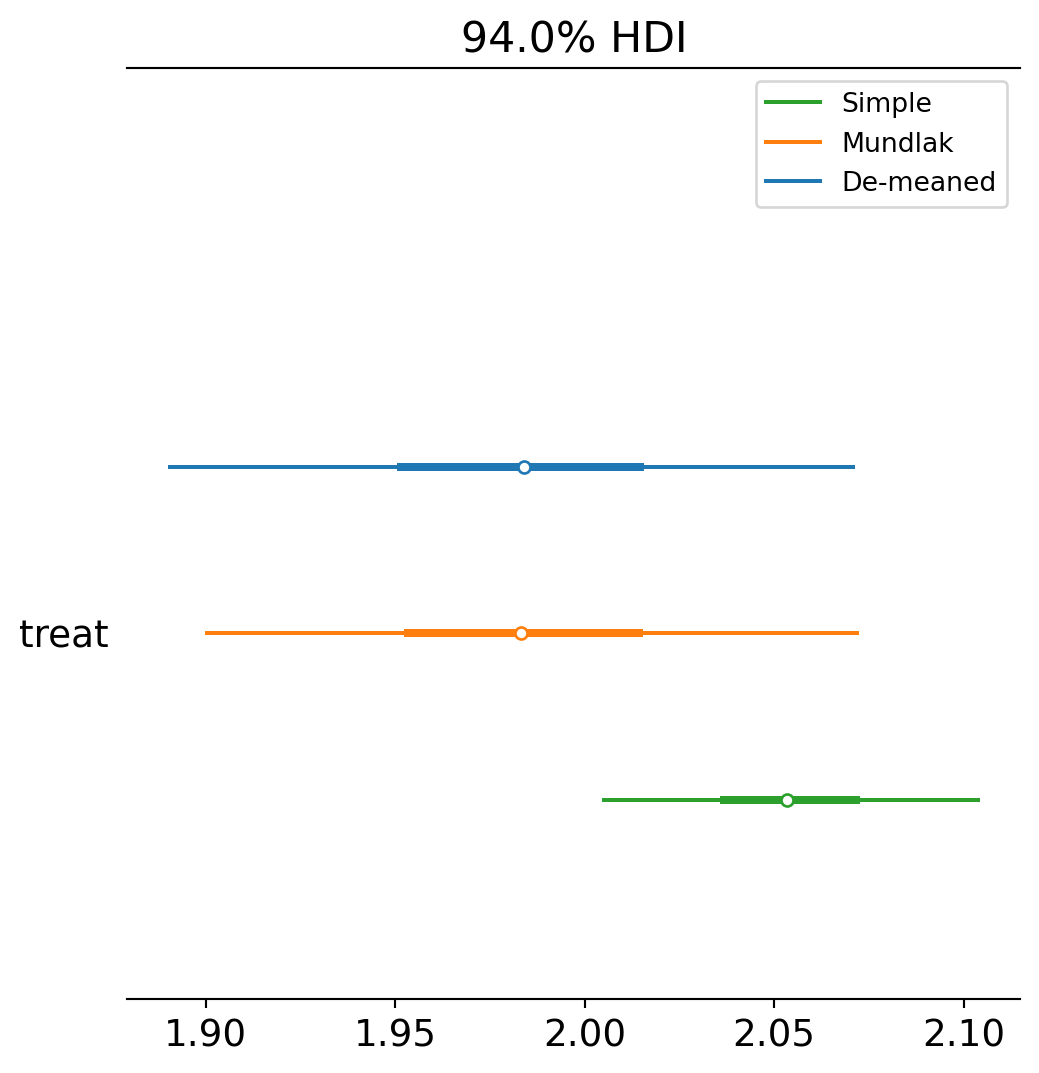

In [46]:
az.plot_forest([idata_twfe_trt_demean, idata_twfe_trt_mundlak, idata_twfe_trt], combined=True, var_names=['treat'], model_names=['De-meaned', 'Mundlak', 'Simple']);

The de-meaned TWFE estimator and the Mundlak specification result in identical estimates and differ from the naive estimate that fails to control group level confounds.

### Functional Form and Saturated Regression

The vanilla TWFE estimator _can_ successfully recover the treatment effects in DiD designs and facilitate event studies of the same. However, the details of the estimation matter because this functional form is not always robust. Here we'll see other options that can recover substantially the same inferences and may prove more robust as we'll see below. The key to each is to articulate enough structural features that allow the model to modify effects based on the suspected group level confounds. 


In [47]:
#| output: false

df_het['state_mean'] = df_het.groupby('state')['treat'].transform(np.mean)
df_het['time_mean'] = df_het.groupby('year')['treat'].transform(np.mean)
df_het['cohort_mean'] = df_het.groupby('group')['treat'].transform(np.mean)

model_twfe_event_1 = bmb.Model(f"dep_var ~ 1 + C(year) + state_mean + C(rel_year, Treatment(reference=-1)) ", df_het)
idata_twfe_event_1 = model_twfe_event_1.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


formula = """ dep_var ~ 1 + time_mean:state_mean + C(rel_year, Treatment(reference=-1))"""
twfe_model_ols = smf.ols(formula, data=df_het).fit()
twfe_model_ols.summary()
param_est = pd.DataFrame(twfe_model_ols.params, columns=['estimate']).iloc[1:-1]
param_est['index_number'] = list(range(len(param_est)))
temp = (param_est.reset_index()
)
param_est = temp[(~temp['index'].str.contains(':')) & (temp['index'].str.contains('rel'))]
param_est.reset_index(inplace=True)


model_twfe_event_2 = bmb.Model(f"dep_var ~ (1 | year) + state_mean + C(rel_year, Treatment(reference=-1)) ", df_het)
idata_twfe_event_2 = model_twfe_event_2.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


Compiling...


Compilation time = 0:00:01.430226


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:02:05.967895


Transforming variables...


Transformation time = 0:00:00.078935


Computing Log Likelihood...


Log Likelihood time = 0:00:01.948121


Compiling...


Compilation time = 0:00:00.862735


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:41.917842


Transforming variables...


Transformation time = 0:00:00.097806


Computing Log Likelihood...


Log Likelihood time = 0:00:01.740349


Having estimated the various alternatives model specifications we compare each against our baseline de-meaned event-study.


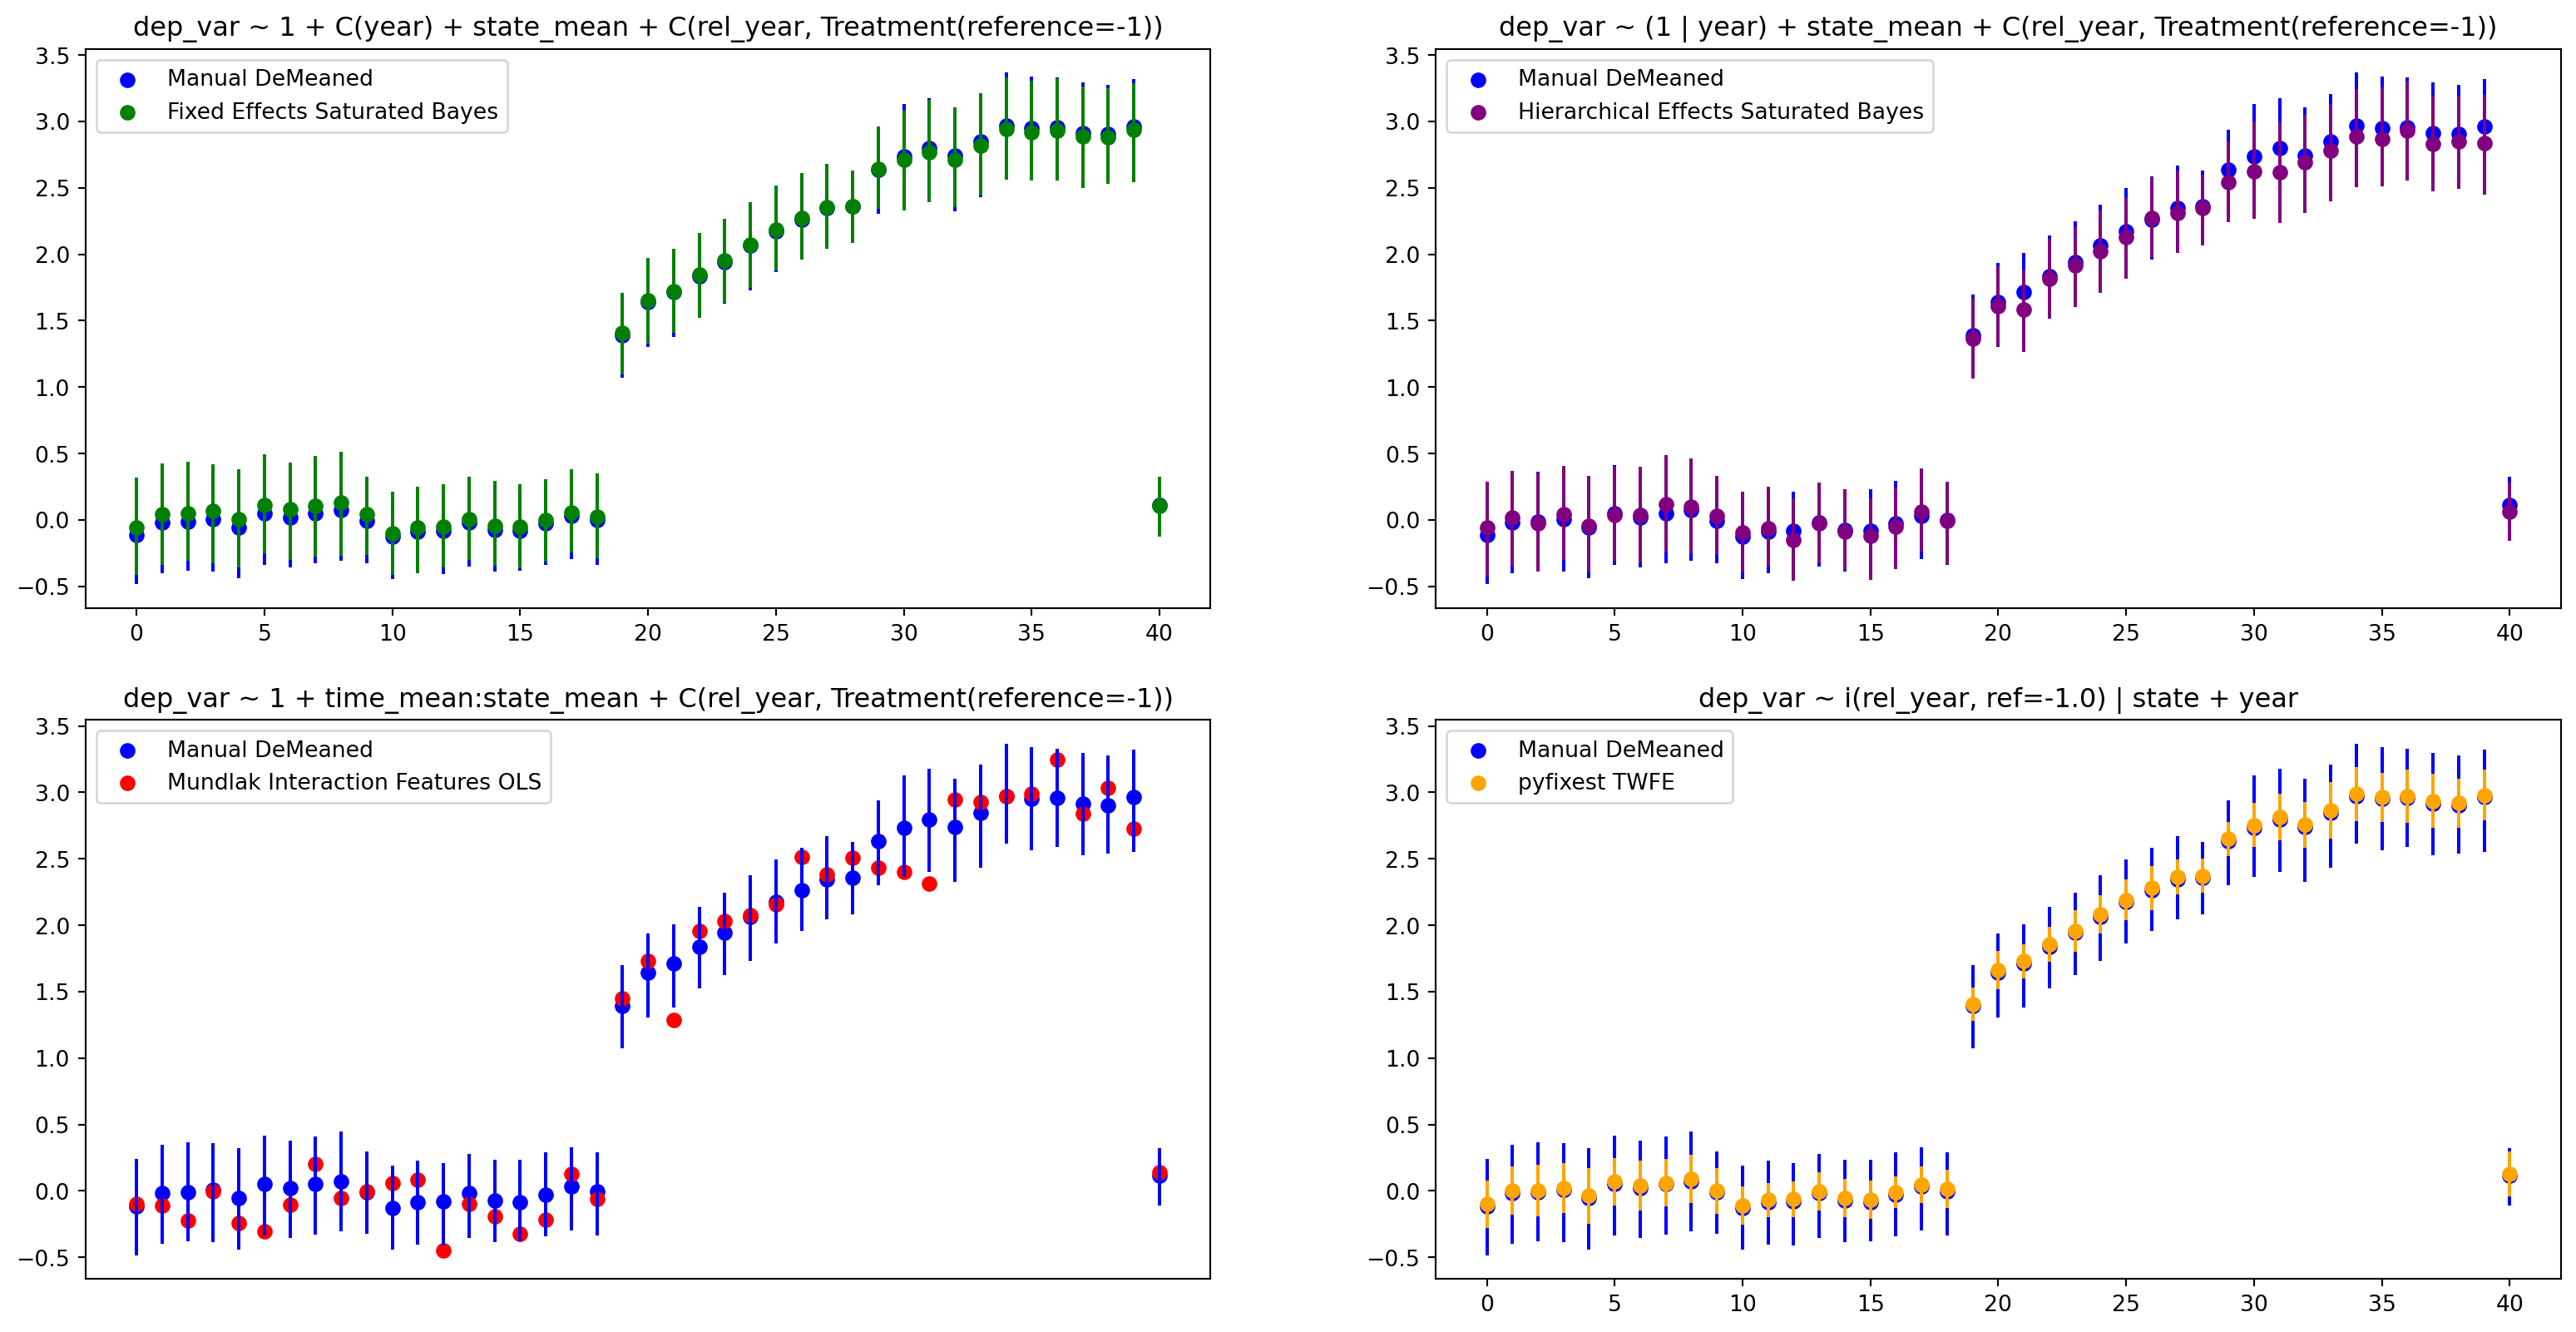

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flatten()
plot_event_study(idata_twfe_event, axs[0], model='Manual DeMeaned')
plot_event_study(idata_twfe_event, axs[1], model='Manual DeMeaned')
plot_event_study(idata_twfe_event, axs[2], model='Manual DeMeaned')
plot_event_study(idata_twfe_event, axs[3], model='Manual DeMeaned')
plot_event_study(idata_twfe_event_1, axs[0], color='green', model='Fixed Effects Saturated Bayes')
plot_event_study(idata_twfe_event_2, axs[1], color='purple', model='Hierarchical Effects Saturated Bayes')
axs[2].scatter(param_est['index'], param_est['estimate'], color='red', label='Mundlak Interaction Features OLS')
tidy = fit_twfe_event.tidy()
xs = range(len(tidy))
tidy.reset_index(inplace=True)
axs[3].scatter(xs, tidy['Estimate'], color='orange', label='pyfixest TWFE')
axs[3].plot([xs, xs], [tidy['2.5%'],tidy['97.5%']], color='orange')
axs[2].set_xticks([])
axs[0].set_title("dep_var ~ 1 + C(year) + state_mean + C(rel_year, Treatment(reference=-1))")
axs[1].set_title("dep_var ~ (1 | year) + state_mean + C(rel_year, Treatment(reference=-1))")
axs[2].set_title("dep_var ~ 1 + time_mean:state_mean + C(rel_year, Treatment(reference=-1))")
axs[3].set_title("dep_var ~ i(rel_year, ref=-1.0) | state + year")
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend();

`

This suggests that there are a variety of functional forms even just using regression specifications that seek to control from different types of group level confounding. In this example data most of the functional forms that seek to control for time and state level effects seem to converge in their answers. We will now switch to an example where the vanilla TWFE breaks down. 

## Issues with TWFE and Richly Parameterised Linear Models

We draw on the example from Pedro Sant'Anna [here](https://psantanna.com/posts/twfe) where it is demonstrated that the vanilla TWFE estimator breaks down under various conditions. These conditions are often related to staggered roll out of a treatment and thereby induces dynamic changes in the treatment group over time. Appropriate inference needs to carefully control for the interaction effects due to staggered treatment. 

Let's generate some data. 

In [49]:
true_mu = 1

def make_data(nobs = 1000, nstates = 40):
    ids = list(range(nobs))
    states = np.random.choice(range(nstates), size=nobs, replace=True)
    unit = pd.DataFrame({'unit': ids, 
                        'state': states, 
                        'unit_fe': np.random.normal(states/5, 1, size=nobs),
                        'mu': true_mu})
    
    year = pd.DataFrame({'year': pd.date_range('1980-01-01', '2010-01-01', freq='y'), 
    'year_fe': np.random.normal(0, 1, 30) })
    year['year'] = year['year'].dt.year

    treat_taus = pd.DataFrame({'state': np.random.choice(range(nstates), size=nstates, replace=False),
    'cohort_year': np.sort([1986, 1992, 1998, 2004]*10)
    })

    cross_join = pd.DataFrame([row for row in product(range(nobs), year['year'].unique())], columns =['unit', 'year'])
    cross_join = cross_join.merge(unit, how='left', left_on='unit', 
    right_on='unit')
    cross_join = cross_join.merge(year, how='left', left_on='year', 
    right_on='year')
    cross_join = cross_join.merge(treat_taus, how='left', left_on='state', right_on='state')
    cross_join = cross_join.assign(
        error = np.random.normal(0, 1, len(cross_join)),
        treat = lambda x: np.where(x['year'] >= x['cohort_year'], 1, 0)
    )
    cross_join = cross_join.assign(tau = np.where(cross_join['treat'] == 1, cross_join['mu'], 0), 
    ).assign(year_fe = lambda x: x['year_fe'] + 0.1*(x['year']-x['cohort_year']))

    cross_join['tau_cum'] = cross_join.groupby('unit')['tau'].transform(np.cumsum)
    cross_join = cross_join.assign(dep_var = lambda x: 2010-x['cohort_year'] + 
    x['unit_fe'] + x['year_fe'] + x['tau_cum'] + x['error'])
    cross_join['rel_year'] =  cross_join['year'] - cross_join['cohort_year']

    
    return cross_join

sim_df = make_data(500, 40)
sim_df.head()

unit  year  state   unit_fe  mu   year_fe  cohort_year     error  treat  \
0     0  1980     12  2.770007   1 -1.443538         1998 -0.883541      0   
1     0  1981     12  2.770007   1 -3.140326         1998  1.044140      0   
2     0  1982     12  2.770007   1 -2.430673         1998  0.276021      0   
3     0  1983     12  2.770007   1 -4.253994         1998  0.181049      0   
4     0  1984     12  2.770007   1 -3.347429         1998 -2.104055      0   

   tau  tau_cum    dep_var  rel_year  
0    0        0  12.442927       -18  
1    0        0  12.673821       -17  
2    0        0  12.615355       -16  
3    0        0  10.697061       -15  
4    0        0   9.318523       -14

We can now plot the staggered nature of the imagined treatment regime. 


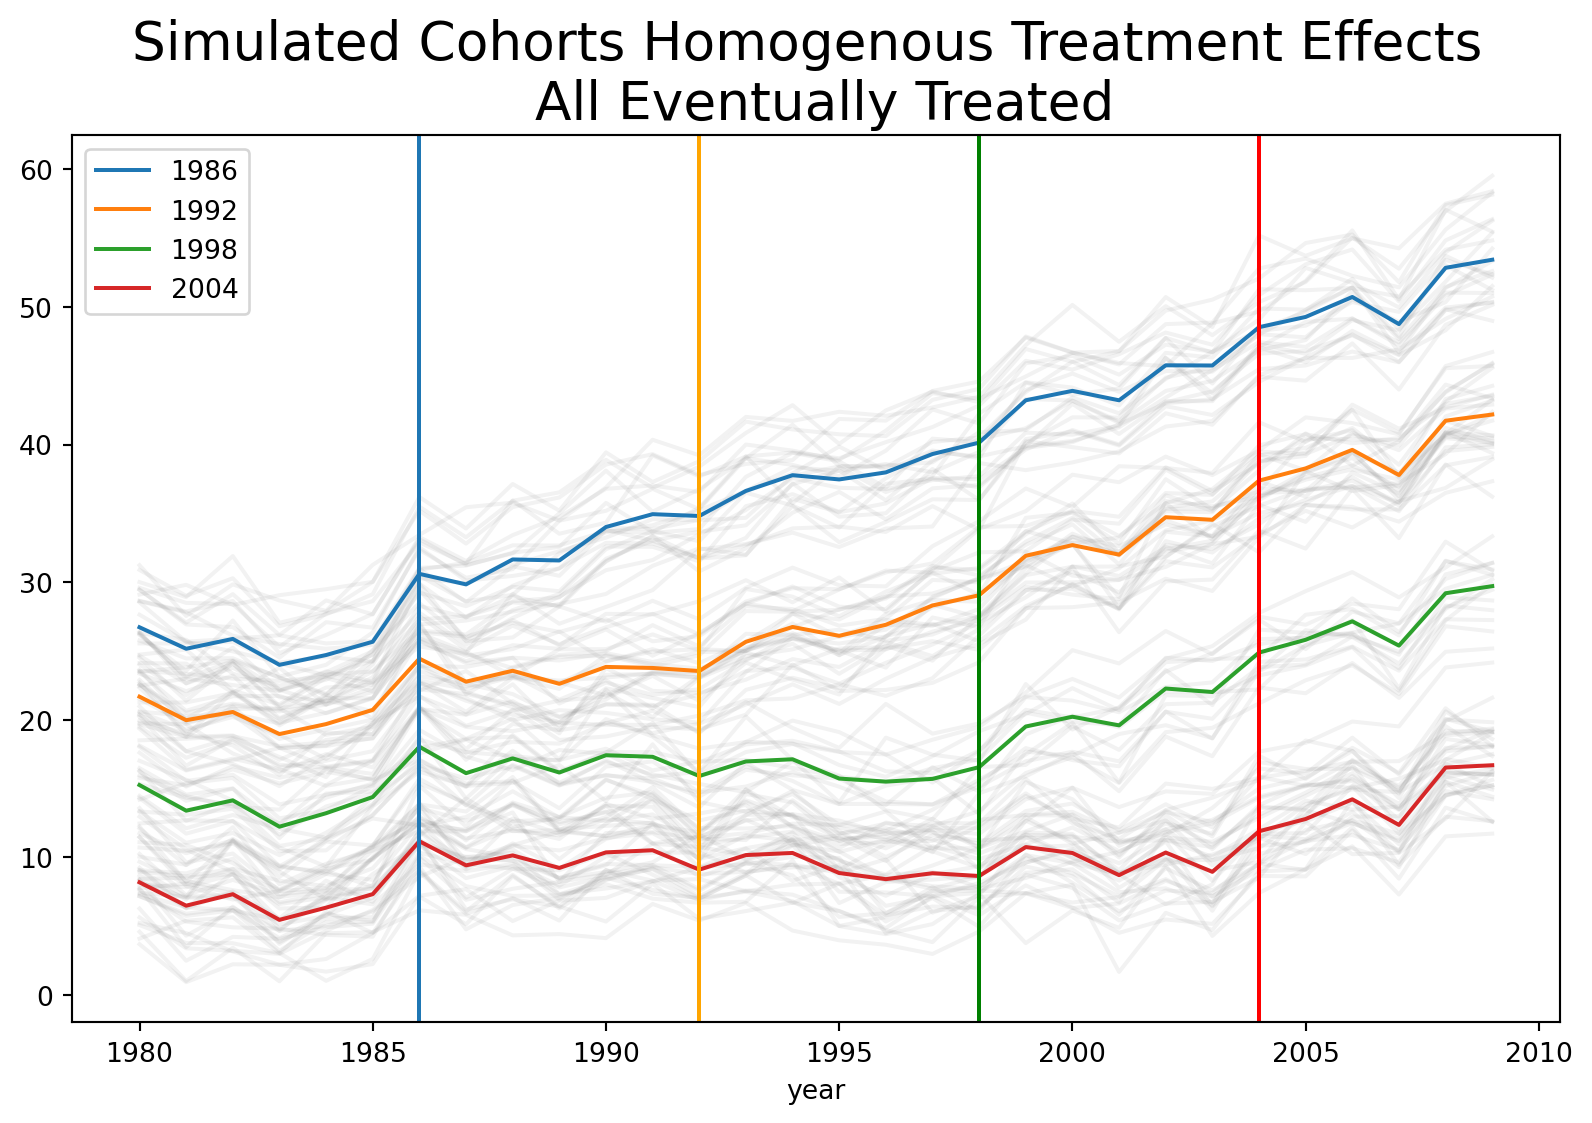

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

for unit in sim_df['unit'].unique()[0:100]:
    temp = sim_df[sim_df['unit'] == unit]
    ax.plot(temp['year'], temp['dep_var'], alpha=0.1, color='grey')

sim_df.groupby(['cohort_year', 'year'])[['dep_var']].mean().reset_index().pivot(index='year', columns='cohort_year', values='dep_var').plot(ax=ax)
ax.axvline(1986)
ax.axvline(1992, color='orange')
ax.axvline(1998, color='green')
ax.axvline(2004, color='red')
ax.set_title("Simulated Cohorts Homogenous Treatment Effects \n All Eventually Treated", fontsize=20)
ax.legend()

This data will present problems for the vanilla TWFE estimator in part because we can see how each cohort receives a treatment and there are periods in the data when no group is in the "control". We can see how this plays out with de-meaning TWFE strategy. 


In [51]:
from pyfixest.did.estimation import did2s, lpdid
fit_twfe = pf.feols(
    "dep_var ~ i(rel_year, ref=-1.0) | state + year",
    sim_df,
    vcov={"CRV1": "state"},
)


figsize = [1200, 400]
fit_twfe.iplot(
    coord_flip=False,
    title="TWFE-Estimator",
    figsize=figsize,
    xintercept=18.5,
    yintercept=0,
).show()

/Users/nathanielforde/mambaforge/envs/pymc_causal/lib/python3.11/site-packages/pyfixest/estimation/feols_.py:1987: UserWarning: 
            The following variables are collinear: ['C(rel_year, contr.treatment(base=-1.0))[T.18]', 'C(rel_year, contr.treatment(base=-1.0))[T.19]', 'C(rel_year, contr.treatment(base=-1.0))[T.20]', 'C(rel_year, contr.treatment(base=-1.0))[T.21]', 'C(rel_year, contr.treatment(base=-1.0))[T.22]', 'C(rel_year, contr.treatment(base=-1.0))[T.23]'].
            The variables are dropped from the model.
            
  warnings.warn(


This is not the expected pattern. For contrast, consider an alternative estimator.


In [52]:
fit_lpdid = lpdid(
    data=sim_df,
    yname="dep_var",
    gname="cohort_year",
    tname="year",
    idname="unit",
    vcov={"CRV1": "state"},
    pre_window=-17,
    post_window=17,
    att=False,
)

fit_lpdid.iplot(
    coord_flip=False,
    title="Local-Projections-Estimator",
    figsize=figsize,
    yintercept=0,
    xintercept=18.5,
).show()

The initial TWFE estimate is frankly bizarre and utterly skewed. Something dreadful has gone wrong under the hood. For contrast, we've included the Local Projections estimator from the `pyfixest` to show that we can recover the actual treatment effect under this event study with alternative strategies. However, there is more machinary involves in the local-projections estimator. Instead we want show how to use mundlak devices to recover more reasonable estimates. No fancy estimators, just more regressions. 


In [53]:
#| output: false

sim_df['unit_mean'] = sim_df.groupby('unit')['treat'].transform(np.mean)

sim_df['state_mean'] = sim_df.groupby('state')['treat'].transform(np.mean)

sim_df['cohort_mean'] = sim_df.groupby('cohort_year')['treat'].transform(np.mean)

sim_df['time_mean'] = sim_df.groupby('year')['treat'].transform(np.mean)


model_twfe = bmb.Model(f"""dep_var ~ 1  + time_mean + state_mean + C(cohort_year) + C(rel_year, Treatment(reference=-1))""", sim_df)

idata_twfe = model_twfe.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


model_twfe1 = bmb.Model(f"""dep_var ~ 1  + time_mean* state_mean + C(cohort_year) + C(rel_year, Treatment(reference=-1))""", sim_df)

idata_twfe1 = model_twfe1.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})


model_twfe2 = bmb.Model(f"""dep_var ~ 1  + cohort_mean: state_mean + C(rel_year, Treatment(reference=-1))""", sim_df)

idata_twfe2 = model_twfe2.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

model_twfe3 = bmb.Model(f"""dep_var ~ (1| year)  + state_mean + C(rel_year, Treatment(reference=-1))""", sim_df)
idata_twfe3 = model_twfe3.fit( inference_method="nuts_numpyro",
    idata_kwargs={"log_likelihood": True})

Compiling...


Compilation time = 0:00:00.738246


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:07:25.707090


Transforming variables...


Transformation time = 0:00:00.102029


Computing Log Likelihood...


Log Likelihood time = 0:00:00.686617


Compiling...


Compilation time = 0:00:00.781869


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:07:47.337415


Transforming variables...


Transformation time = 0:00:00.060718


Computing Log Likelihood...


Log Likelihood time = 0:00:00.651695


Compiling...


Compilation time = 0:00:00.565418


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:08.313124


Transforming variables...


Transformation time = 0:00:00.043528


Computing Log Likelihood...


Log Likelihood time = 0:00:00.709436


Compiling...


Compilation time = 0:00:01.193776


Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:01:23.217563


Transforming variables...


Transformation time = 0:00:00.067475


Computing Log Likelihood...


Log Likelihood time = 0:00:00.732961


These latter models will recover the appropriate treatment effects with slight variations due to the functional form. 


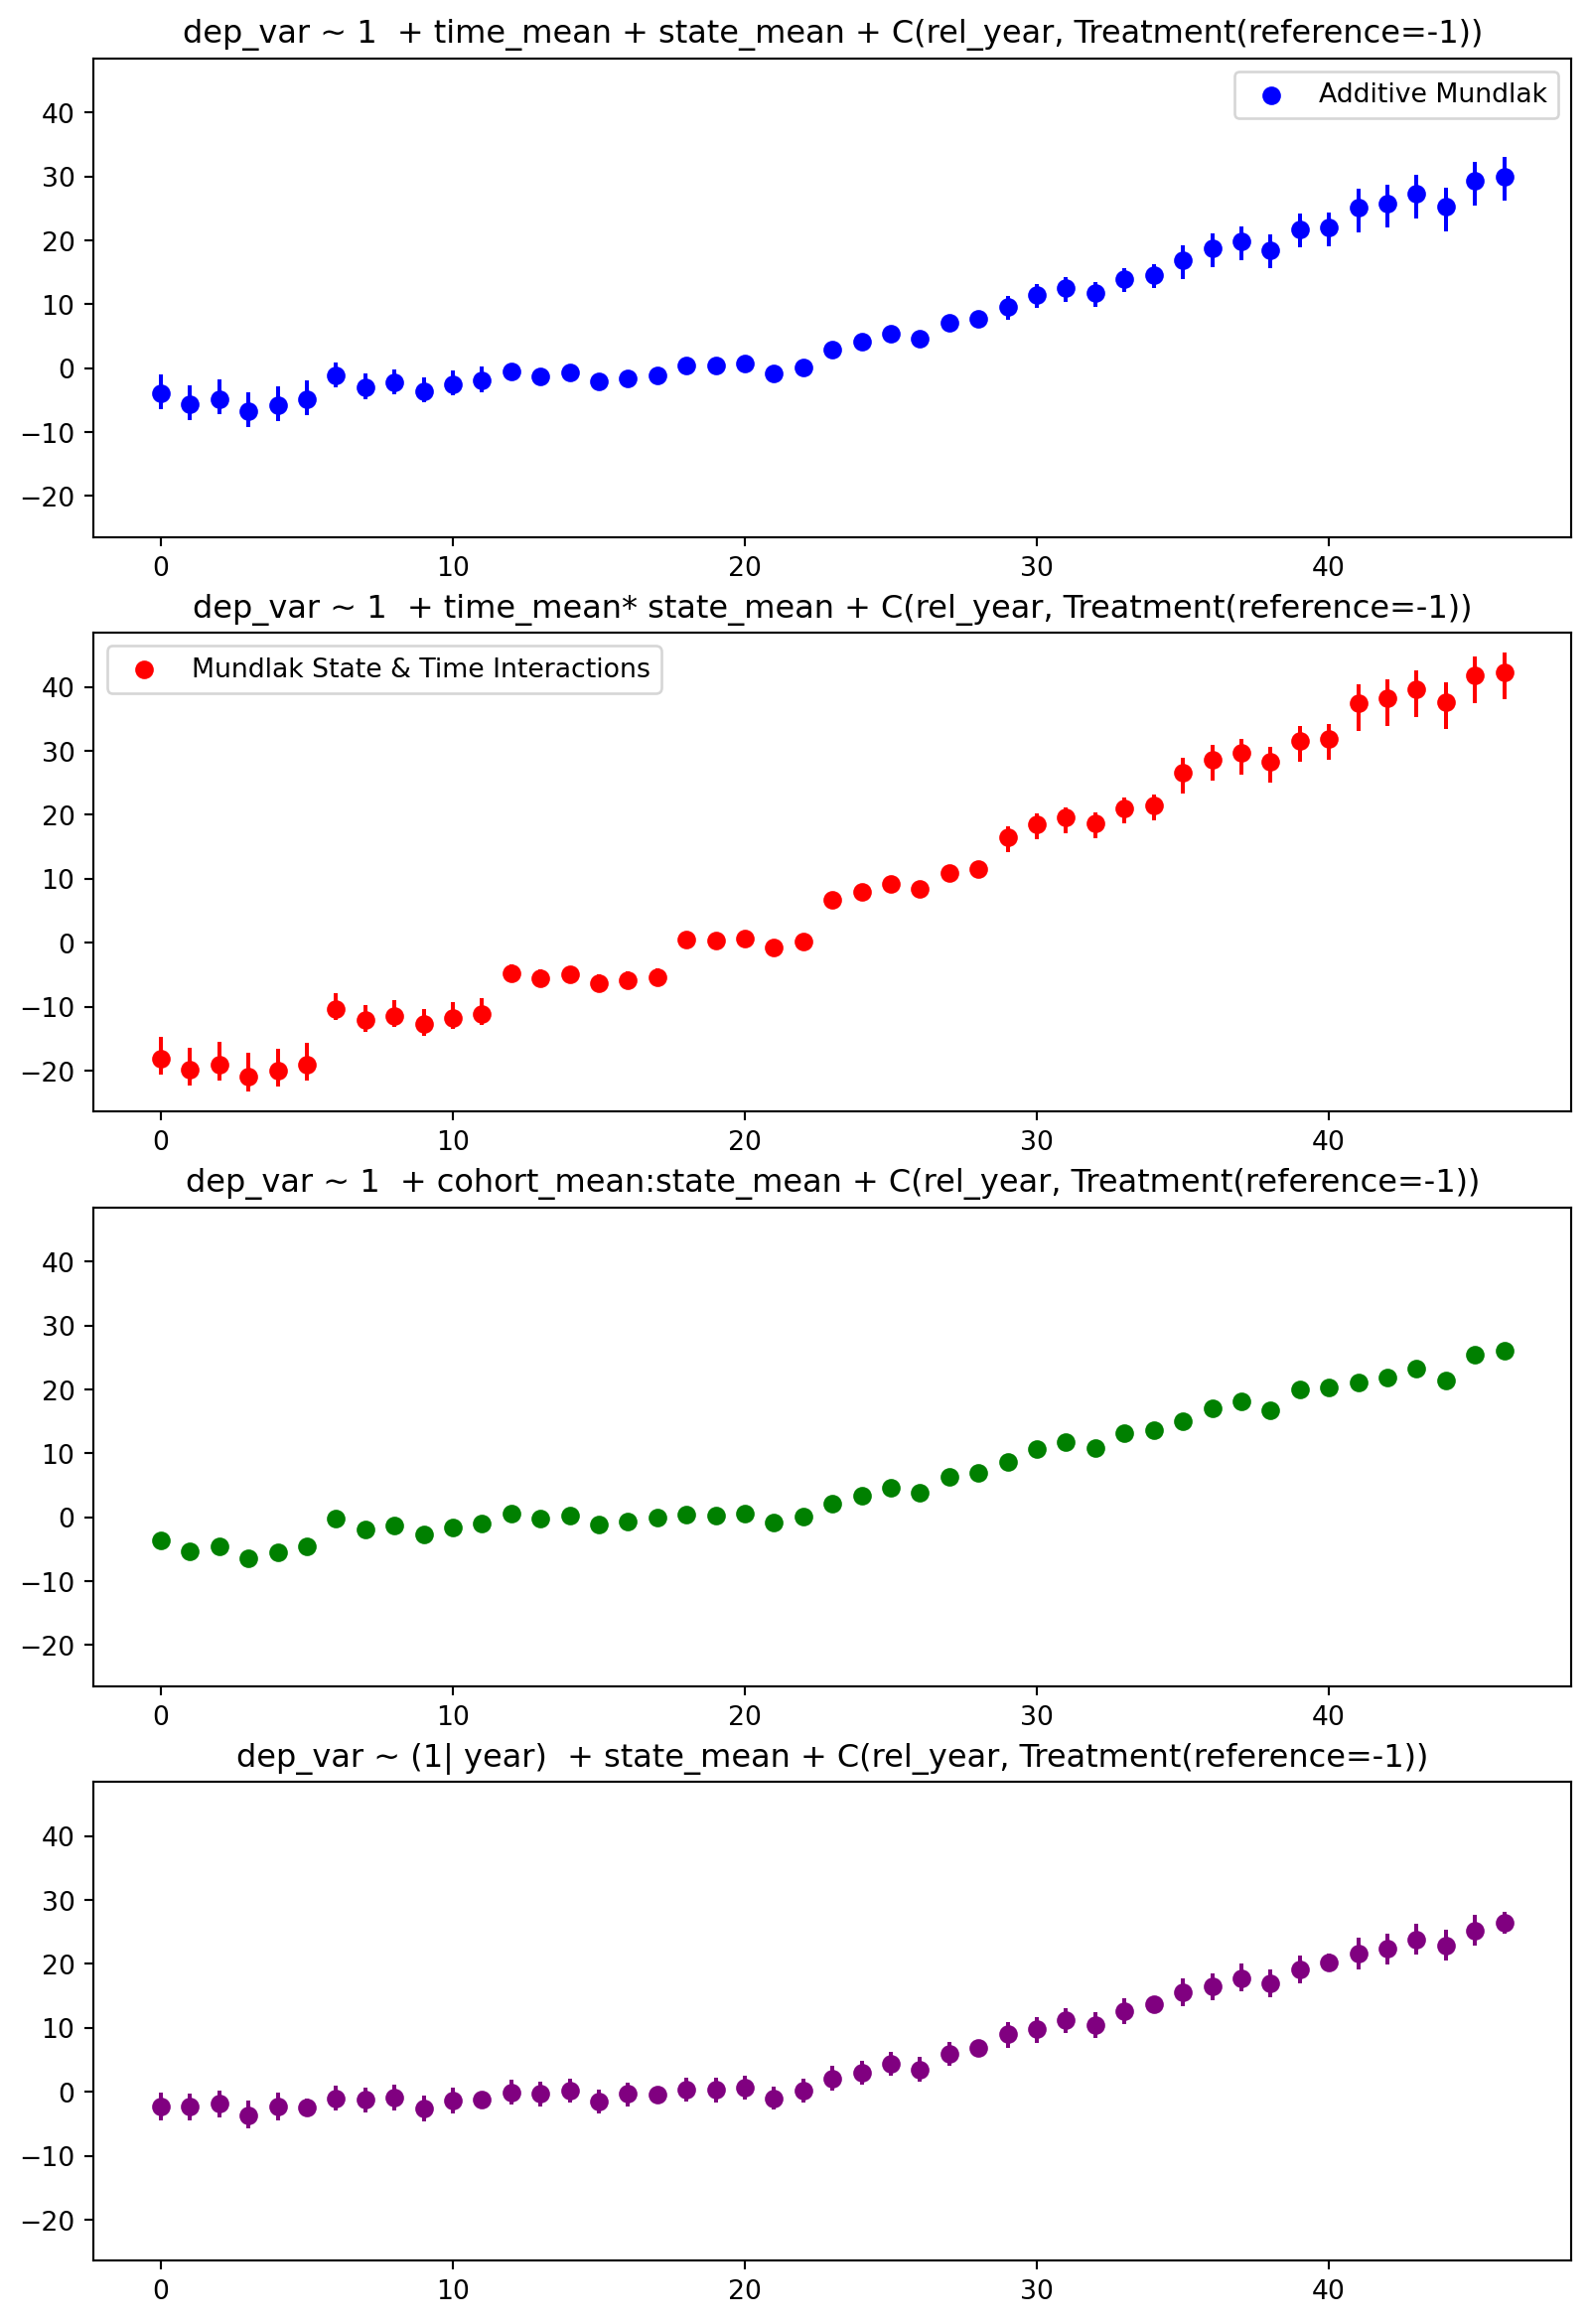

In [54]:
fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharey=True)
axs = axs.flatten()
plot_event_study(idata_twfe, ax=axs[0], model='Additive Mundlak')
plot_event_study(idata_twfe1, ax=axs[1], color='red', model='Mundlak State & Time Interactions')
plot_event_study(idata_twfe2, ax=axs[2], color='green', model='Mundlak Cohort & State Interactions')
plot_event_study(idata_twfe3, ax=axs[3], color='purple', model='Mundlak Cohort & State Interactions')
axs[0].set_title("dep_var ~ 1  + time_mean + state_mean + C(rel_year, Treatment(reference=-1))")
axs[1].set_title("dep_var ~ 1  + time_mean* state_mean + C(rel_year, Treatment(reference=-1))")
axs[2].set_title("dep_var ~ 1  + cohort_mean:state_mean + C(rel_year, Treatment(reference=-1))")
axs[3].set_title("dep_var ~ (1| year)  + state_mean + C(rel_year, Treatment(reference=-1))")
axs[0].legend()
axs[1].legend()

Note how the the naive mundlak approach replicates the odd behaviour we saw in the TWFE estimation routine above. Adding additional interactions and controlling for the staggered launch dates seems to help isolate the real pattern in the data. We've seen approximate success in a number of these richly parameterised versions of simple event study regressions. But the idiosyncracies of the sample contort and distort the estimates away from the true values. We might hope for more stability in expectation over repeated draws from this kind of data-generating process. 


Text(0.5, 1.0, 'Bootstrapped Estimates of Event Study DGP \n\n dep_var ~ 1 + C(cohort_year) + time_mean:unit_mean + C(rel_year, Treatment(reference=-1))')

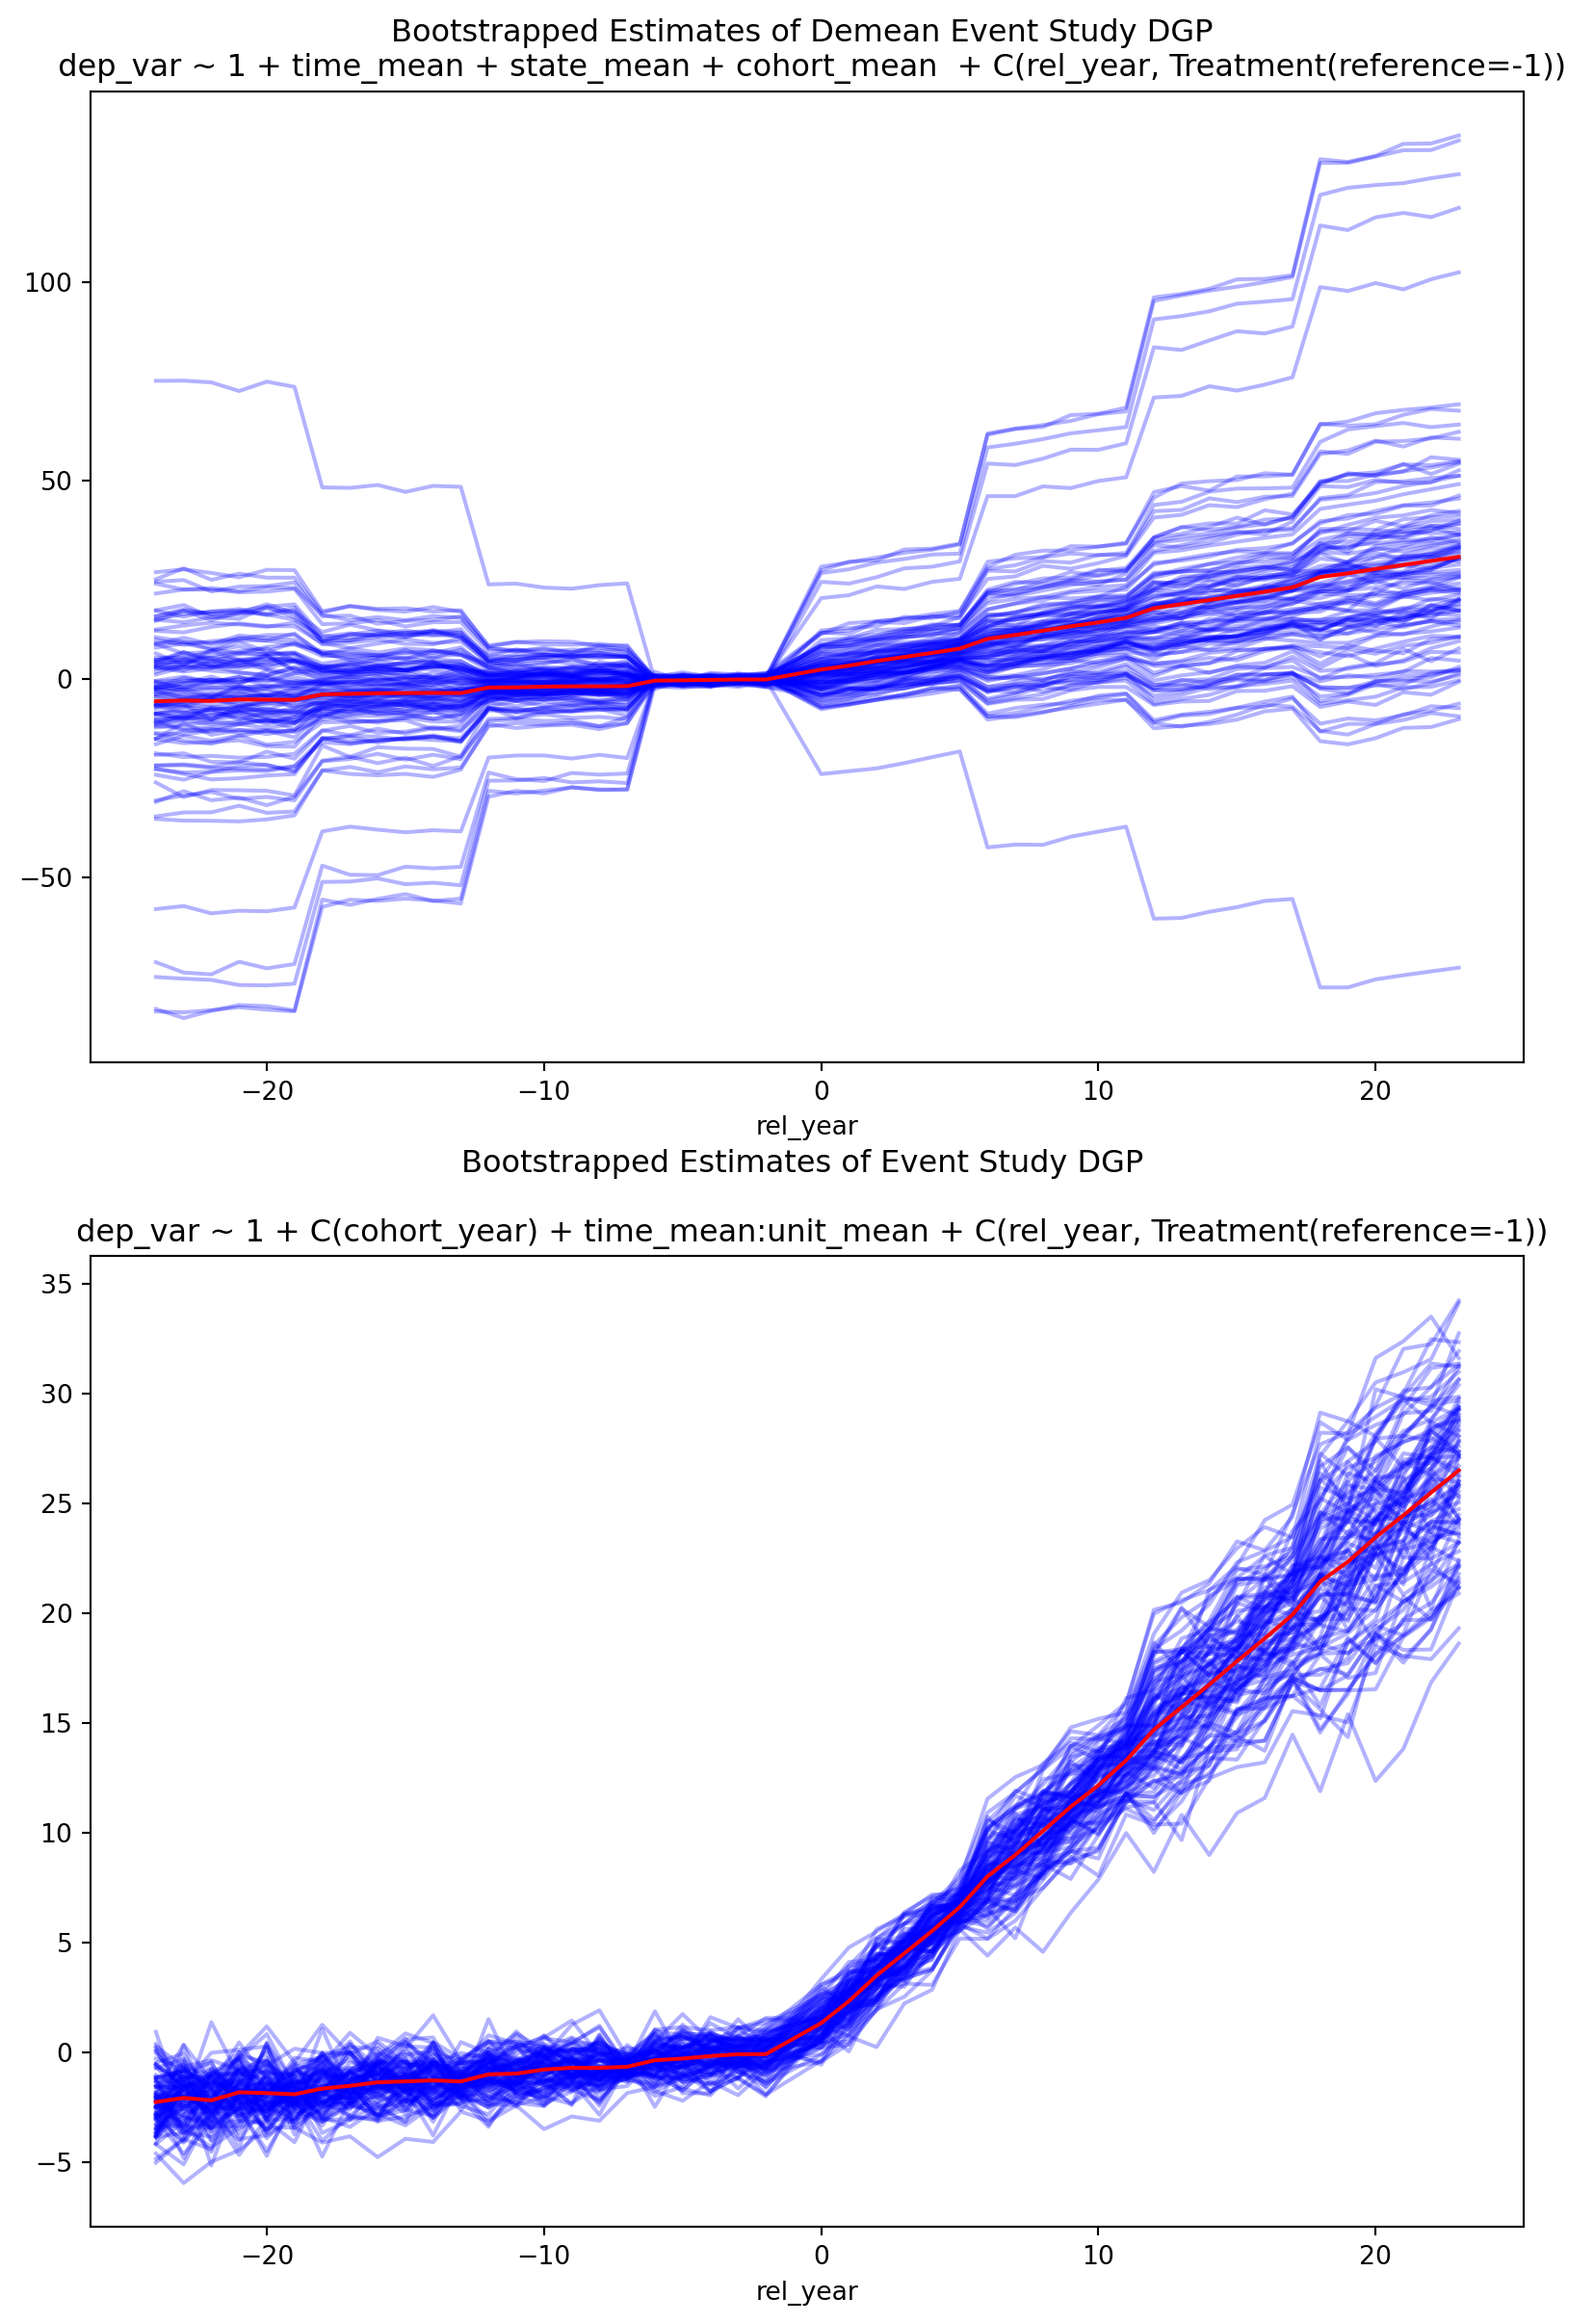

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(10, 15))
axs = axs.flatten()
event_coefs = []
event_coefs1 = []

def fit_ols(formula, df_het):
    twfe_model_ols = smf.ols(formula, data=df_het).fit()
    twfe_model_ols.summary()
    param_est = pd.DataFrame(twfe_model_ols.params, columns=['estimate']).iloc[1:-1]
    param_est['index_number'] = list(range(len(param_est)))
    temp = (param_est.reset_index())
    param_est = temp[(~temp['index'].str.contains(':')) & (temp['index'].str.contains('rel'))]
    param_est.reset_index(inplace=True)
    try:
        param_est['rel_year'] =(param_est['index'].str.split('[', expand=True)[1].str.replace('T.', '')
        .str.replace(']', ''))
    except Exception as e:
        param_est['rel_year'] = param_est['level_0'] - 22
    param_est['rel_year'] = param_est['rel_year'].astype(int)
    param_est.set_index('rel_year', inplace=True)
    return param_est

for i in range(100):
    df_het = make_data(500, 40)
    df_het['state_mean'] = df_het.groupby('state')['treat'].transform(np.mean)
    df_het['time_mean'] = df_het.groupby('year')['treat'].transform(np.mean)
    df_het['cohort_mean'] = df_het.groupby('cohort_year')['treat'].transform(np.mean)
    df_het['unit_mean'] = df_het.groupby('unit')['treat'].transform(np.mean)

    formula = """ dep_var ~ 1 + time_mean + state_mean + cohort_mean  + C(rel_year, Treatment(reference=-1)) """
    formula1 = """ dep_var ~ 1 + C(cohort_year) + time_mean:unit_mean + C(rel_year, Treatment(reference=-1))"""

    param_est = fit_ols(formula, df_het)
    axs[0].plot(param_est['estimate'], color='blue', alpha=0.3)
    event_coefs.append(param_est['estimate'])
    param_est1 = fit_ols(formula1, df_het)
    axs[1].plot(param_est1['estimate'], color='blue', alpha=0.3)
    event_coefs1.append(param_est1['estimate'])

bootstrap_df = pd.DataFrame(event_coefs)
mean_df = bootstrap_df.mean(axis=0)
mean_df.index = param_est.index
mean_df.plot(ax=axs[0], color='red')
axs[0].set_title(f"""Bootstrapped Estimates of Demean Event Study DGP \n {formula}""")

bootstrap_df1 = pd.DataFrame(event_coefs1)
mean_df = bootstrap_df1.mean(axis=0)
mean_df.index = param_est1.index
mean_df.plot(ax=axs[1], color='red')
axs[1].set_title(f"""Bootstrapped Estimates of Event Study DGP \n
{formula1}""")

We can also compare these models on standard adequacy measures. 


In [56]:
az.compare({'fe_mundlak_naive': idata_twfe, 
            'mundlak_state_time_interactions_cohort': idata_twfe1, 
            'mundlak_cohort_state_interactions': idata_twfe2, 
            'mundlak_state_hierarchical_year': idata_twfe3})

rank      elpd_loo      p_loo  \
mundlak_state_hierarchical_year            0 -35911.645075  71.387924   
mundlak_state_time_interactions_cohort     1 -36426.927839  52.769884   
fe_mundlak_naive                           2 -36588.252252  51.363853   
mundlak_cohort_state_interactions          3 -38253.296743  46.234056   

                                          elpd_diff        weight         se  \
mundlak_state_hierarchical_year            0.000000  8.149328e-01  72.041537   
mundlak_state_time_interactions_cohort   515.282764  1.850676e-01  74.492851   
fe_mundlak_naive                         676.607177  3.115000e-07  75.202968   
mundlak_cohort_state_interactions       2341.651668  0.000000e+00  78.030849   

                                              dse  warning scale  
mundlak_state_hierarchical_year          0.000000    False   log  
mundlak_state_time_interactions_cohort  41.223769    False   log  
fe_mundlak_naive                        43.181744    False   log  
mundlak_cohort_state_interactions       49.571127    False   log

## Conclusion
